# **Imports**

In [94]:
import pymupdf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.signal import savgol_filter  # For smoothing
from scipy.optimize import minimize
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# **LOAD Experimental XANES for MnOx**

In [95]:
# Load the Excel files (make sure the paths are correct)
Mn_2 = 'C:\\Users\\Lungelo\\OneDrive - University of Cape Town\\Desktop\\CHE4045\\code\\MnO-Mn2p-od1.txt'
Mn_3 = 'C:\\Users\\Lungelo\\OneDrive - University of Cape Town\\Desktop\\CHE4045\\code\\Mn2O3-Mn2p-od1.txt'
Mn_4 = 'C:\\Users\\Lungelo\\OneDrive - University of Cape Town\\Desktop\\CHE4045\\code\\MnO2-Mn2p-od1.txt'
MnO_exp = pd.read_csv(Mn_2, delim_whitespace=True, comment='%', header=None, names=["x", "y"])
Mn2O3_exp = pd.read_csv(Mn_3, delim_whitespace=True, comment='%', header=None, names=["x", "y"])
MnO2_exp = pd.read_csv(Mn_4, delim_whitespace=True, comment='%', header=None, names=["x", "y"])

# Filter the DataFrame to only include rows where Energy >= 6520
MnO_exp = MnO_exp[(MnO_exp["x"] >= 648) & (MnO_exp["x"] <= 670)]
Mn2O3_exp = Mn2O3_exp[(Mn2O3_exp["x"] >= 648) & (Mn2O3_exp["x"] <= 670)]
MnO2_exp = MnO2_exp[(MnO2_exp["x"] >= 649.3) & (MnO2_exp["x"] <= 670)]

C:\Users\Lungelo\AppData\Local\Temp\ipykernel_25052\332479372.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  MnO_exp = pd.read_csv(Mn_2, delim_whitespace=True, comment='%', header=None, names=["x", "y"])
C:\Users\Lungelo\AppData\Local\Temp\ipykernel_25052\332479372.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Mn2O3_exp = pd.read_csv(Mn_3, delim_whitespace=True, comment='%', header=None, names=["x", "y"])
C:\Users\Lungelo\AppData\Local\Temp\ipykernel_25052\332479372.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  MnO2_exp = pd.read_csv(Mn_4, delim_whitespace=True, comment='%', header=None, names=["x", "y"])


<Figure size 500x500 with 0 Axes>

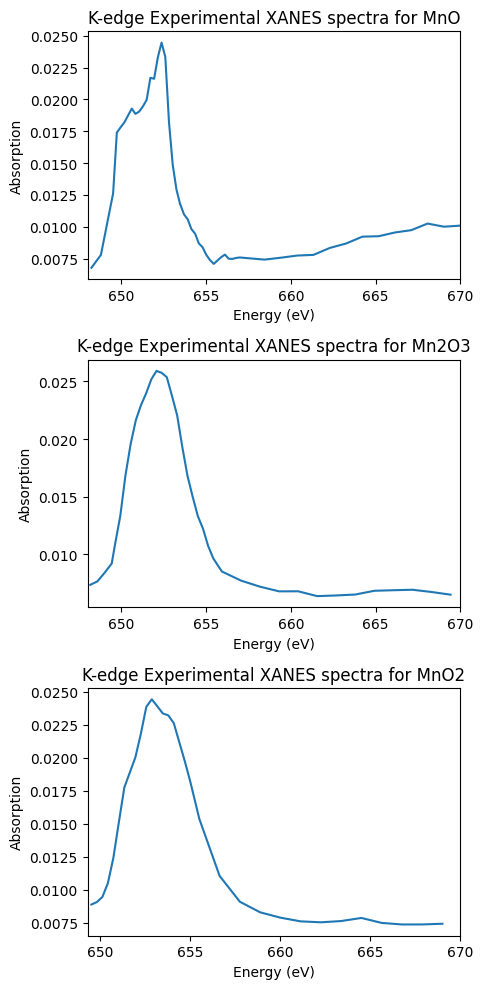

In [96]:
plt.figure(figsize=(5, 5))  # Set the figure size if needed
# Create subplots with 3 rows, 1 column (one for each dataset)
fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Adjust the figure size as needed

# MnO
axes[0].plot(MnO_exp["x"], MnO_exp["y"])
axes[0].set_xlim(648, 670)
axes[0].set_xlabel('Energy (eV)')
axes[0].set_ylabel('Absorption')
axes[0].set_title('K-edge Experimental XANES spectra for MnO')

# Mn2O3
axes[1].plot(Mn2O3_exp["x"], Mn2O3_exp["y"])
axes[1].set_xlim(648, 670)
axes[1].set_xlabel('Energy (eV)')
axes[1].set_ylabel('Absorption')
axes[1].set_title('K-edge Experimental XANES spectra for Mn2O3')

# MnO2
axes[2].plot(MnO2_exp["x"], MnO2_exp["y"])
axes[2].set_xlim(649.3, 670)
axes[2].set_xlabel('Energy (eV)')
axes[2].set_ylabel('Absorption')
axes[2].set_title('K-edge Experimental XANES spectra for MnO2')

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()

# **EXTRACT E₀**

MnO E₀: 649.51 eV


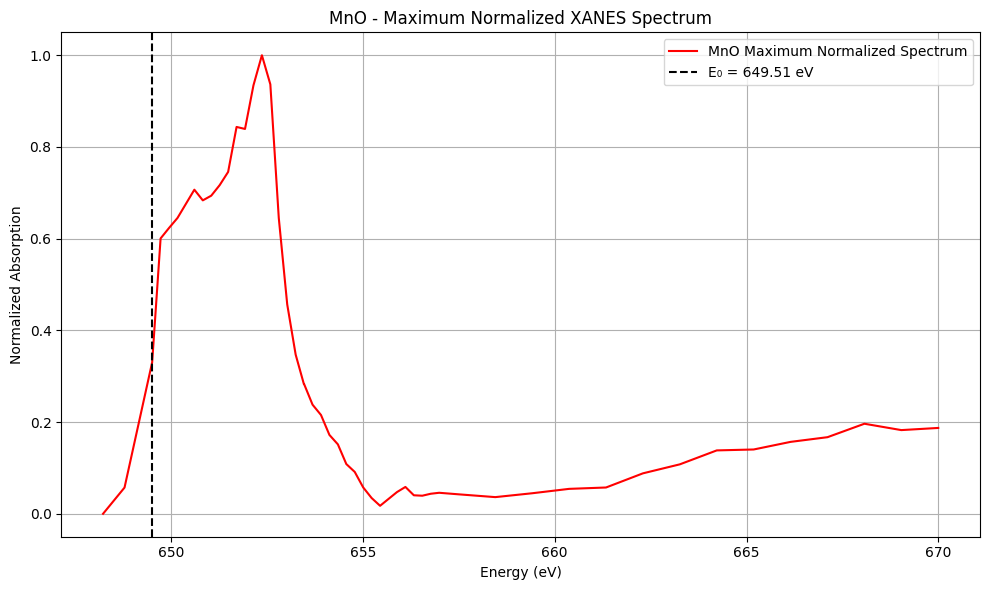

Mn2O3 E₀: 650.24 eV


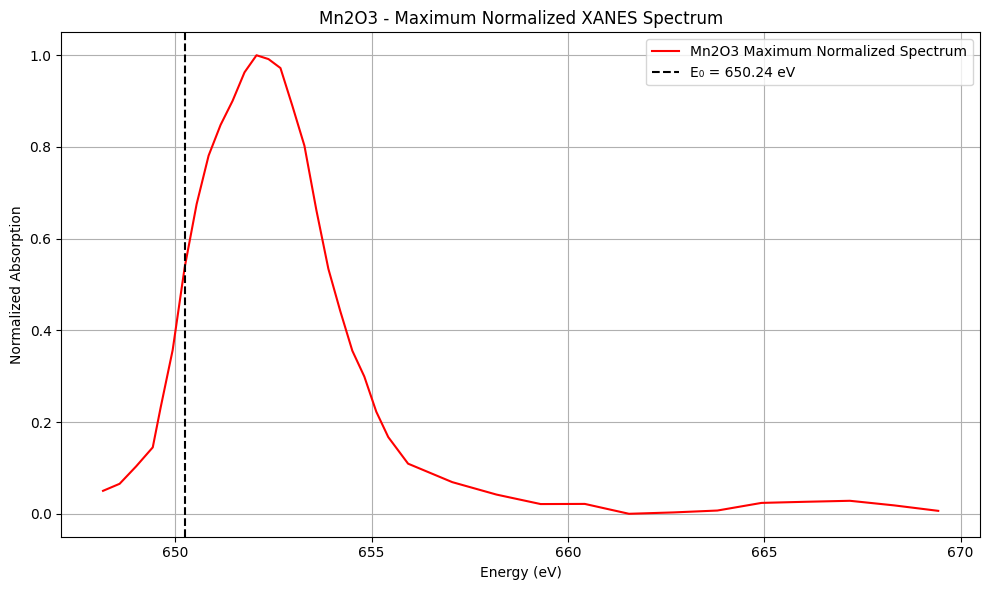

MnO2 E₀: 651.04 eV


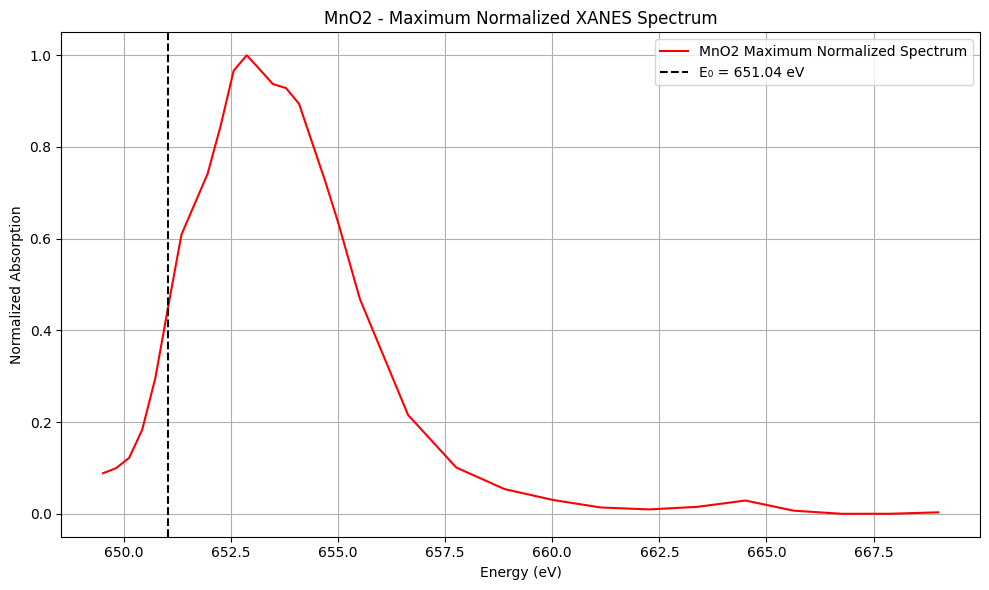

In [97]:
# Function to calculate E₀ from the first derivative
def calculate_E0(x, y):
    dy_dx = np.gradient(y, x)
    
    if len(dy_dx) == 0:
        raise ValueError(f"Unable to calculate E₀: derivative array is empty.")
    
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]  # This should return a single scalar value
    return E0

# Function to shift data to zero
def shift_to_zero(y):
    min_y = np.min(y)
    return y - min_y if min_y >= 0 else y + abs(min_y)

# Function to normalize the absorption data
def normalize_max(y):
    return y / np.max(y)

# Function to normalize and plot the structure's XANES spectrum, and overwrite the original data
def normalize_and_plot_structure_max(x, y, structure_name, df):
    global E0_MnO_exp, E0_Mn2O3_exp, E0_MnO2_exp  # Use global variables

    # Ensure that x and y are numpy arrays for consistency
    x = np.array(x)
    y = np.array(y)

    # Calculate E₀ from the first derivative
    try:
        E0 = calculate_E0(x, y)
    except ValueError as e:
        print(f"Error calculating E₀ for {structure_name}: {e}")
        return

    # Store E0 values in the appropriate global variable
    if structure_name == "MnO":
        E0_MnO_exp = E0
    elif structure_name == "Mn2O3":
        E0_Mn2O3_exp = E0
    elif structure_name == "MnO2":
        E0_MnO2_exp = E0

    print(f"{structure_name} E₀: {E0} eV")

    # Shift data to ensure the minimum value is 0
    shifted_y = shift_to_zero(y)

    # Perform maximum normalization after shifting the data
    normalized_y = normalize_max(shifted_y)

    # Overwrite the old y-values in the DataFrame with the normalized values
    df['y'] = normalized_y

    # Create two subplots: one for original and one for normalized
    fig,  ax2 = plt.subplots(1, 1, figsize=(10, 6))


    # Plot the normalized spectrum on the second axis
    ax2.plot(x, normalized_y, label=f'{structure_name} Maximum Normalized Spectrum', color='red')
    
    # Plot E₀ if it's a scalar value
    if np.isscalar(E0):
        ax2.axvline(E0, color='k', linestyle='--', label=f'E₀ = {E0} eV')
    
    ax2.set_xlabel('Energy (eV)')
    ax2.set_ylabel('Normalized Absorption')
    ax2.set_title(f'{structure_name} - Maximum Normalized XANES Spectrum')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()  # Ensure proper spacing between plots
    plt.show()

# Example usage: Ensure that the 'x' and 'y' columns exist and use the correct DataFrame
try:
    x_MnO = MnO_exp['x']
    y_MnO = MnO_exp['y']
    normalize_and_plot_structure_max(x_MnO, y_MnO, "MnO", MnO_exp)
except KeyError as e:
    print(f"KeyError encountered for MnO: {e}")

# Repeat for Mn2O3 and MnO2
try:
    x_Mn2O3 = Mn2O3_exp['x']
    y_Mn2O3 = Mn2O3_exp['y']
    normalize_and_plot_structure_max(x_Mn2O3, y_Mn2O3, "Mn2O3", Mn2O3_exp)
except KeyError as e:
    print(f"KeyError encountered for Mn2O3: {e}")

try:
    x_MnO2 = MnO2_exp['x']
    y_MnO2 = MnO2_exp['y']
    normalize_and_plot_structure_max(x_MnO2, y_MnO2, "MnO2", MnO2_exp)
except KeyError as e:
    print(f"KeyError encountered for MnO2: {e}")

# **EXTRACT WHITE-LINE & POST-EDGE MAXIMUM**

White-line for MnO: 652.37 eV
Detected Peaks (truning points) MnO at x-coordinates (eV): [650.61  651.71  652.37  656.11  656.99  668.072]
White-line for Mn2O3: 652.07 eV
Detected Peaks (truning points) Mn2O3 at x-coordinates (eV): [652.07 660.43 667.18]
White-line for MnO2: 652.87 eV
Detected Peaks (truning points) MnO2 at x-coordinates (eV): [652.87 664.51]


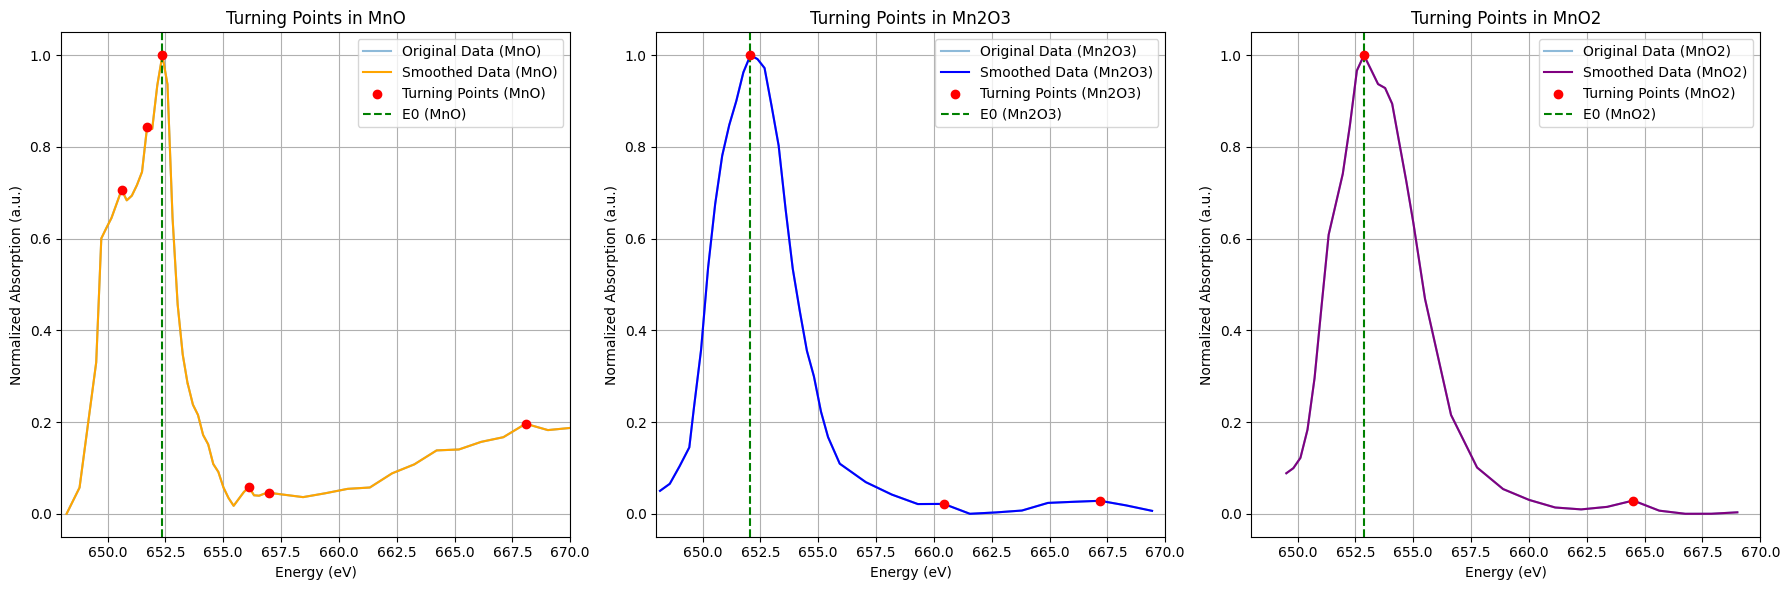

In [98]:
# Function to process each structure (smoothing, peak detection, and plotting)
def process_structure(ax, data, label, color):
    # Access the 'x' and 'y' columns
    x = data["x"].values  # Convert to numpy array for indexing
    y = data["y"].values

    # # Smooth the data to reduce noise
    # y_smooth = gaussian_filter1d(y, sigma=0.00000001)
    # data["y_smooth"] = y_smooth

    # Find peaks in the smoothed data
    peaks, _ = find_peaks(y, height=0)  # Adjust height as needed

    # Extract the x-coordinates of the detected peaks
    turning_points_x = x[peaks]
    turning_points_y = y[peaks]
    max_y = y.argmax()
    x_max_y = x[max_y]
    
    # Call out the E0 (x_max_y) value
    print(f'White-line for {label}: {x_max_y} eV')

    # Print the detected turning points
    print(f'Detected Peaks (truning points) {label} at x-coordinates (eV): {turning_points_x}')

    # Plot on the provided axis
    ax.plot(x, y, label=f'Original Data ({label})', alpha=0.5)
    ax.plot(x, y, label=f'Smoothed Data ({label})', color=color)
    ax.scatter(turning_points_x, turning_points_y, color='red', label=f'Turning Points ({label})', zorder=5)
    ax.axvline(x=x_max_y, color='green', linestyle='--', label=f'E0 ({label})')
    ax.set_title(f'Turning Points in {label}')
    ax.set_xlabel('Energy (eV)')
    ax.set_ylabel('Normalized Absorption (a.u.)')
    ax.legend()
    ax.grid(True)
    ax.set_xlim([648, 670])  # Focus on the relevant energy range

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figure size

# Process MnO_exp on the first axis
process_structure(axs[0], MnO_exp, label="MnO", color='orange')

# Process Mn2O3_exp on the second axis
process_structure(axs[1], Mn2O3_exp, label="Mn2O3", color='blue')

# Process MnO2_exp on the third axis
process_structure(axs[2], MnO2_exp, label="MnO2", color='purple')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


# **EXTRACT PRE-EDGE**

Minima in pre-edge region for MnO:


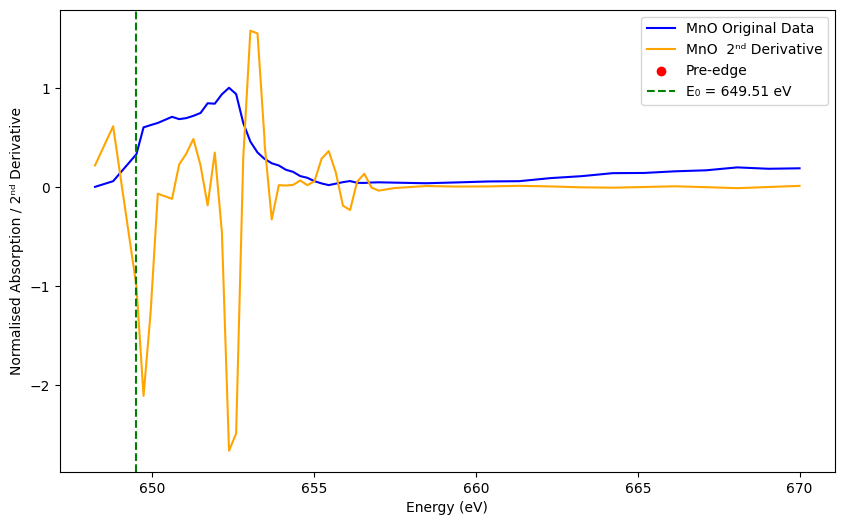

Minima in pre-edge region for Mn₂O₃:


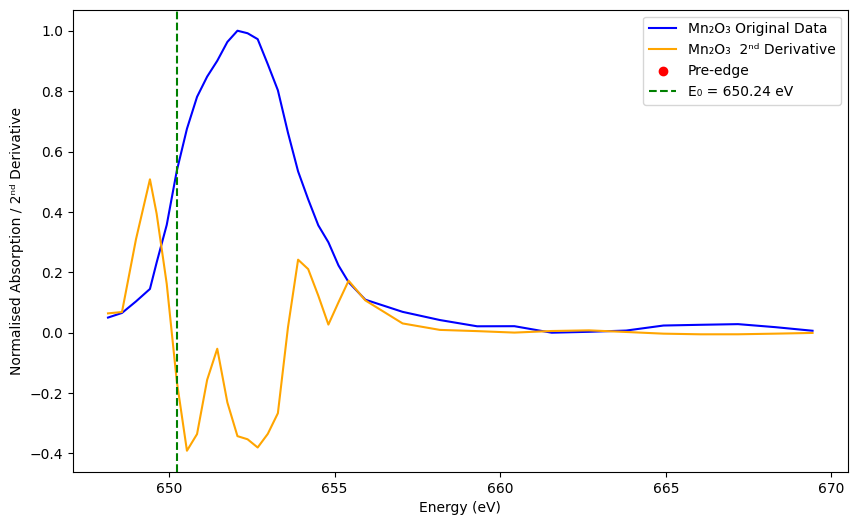

Minima in pre-edge region for MnO₂:


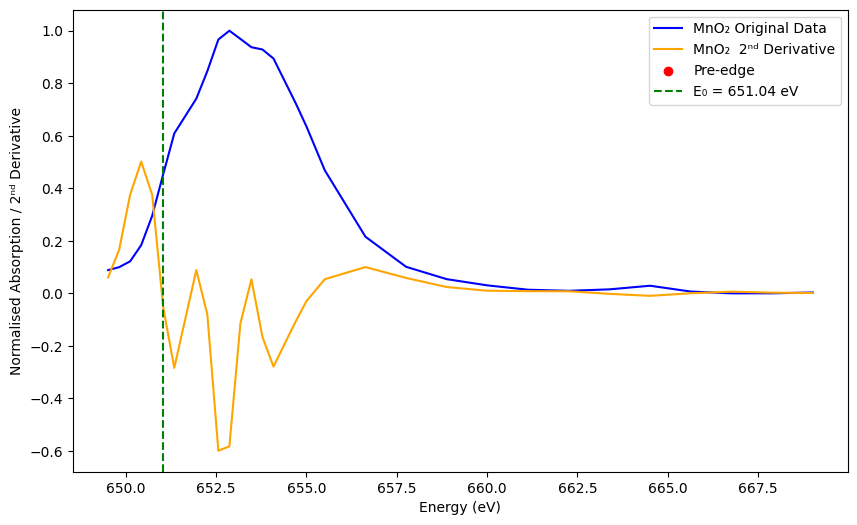

In [99]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c


# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx


# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Ensure we're working with numpy arrays to avoid pandas index issues
    x = np.array(x)
    y = np.array(y)
    
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)


    # Restrict to pre-edge region (before E₀)
    pre_edge_mask = (x < E0)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    
    # Find the minima points where the second derivative changes sign (indicating a trough)
    min_indices = np.where(np.diff(np.sign(pre_edge_d2y_dx2)) == 2)[0]
    
    # Get the x and y values at the minima points in the pre-edge region
    x_min = pre_edge_x[min_indices]
    y_min = y[pre_edge_mask][min_indices]
    
    # Display the minimum x and y values
    print(f"Minima in pre-edge region for {structure_name}:")
    for i, (x_val, y_val) in enumerate(zip(x_min, y_min)):
        print(f"  Minimum {i+1}: x = {x_val:.2f}, y = {y_val:.4f}")


    # Plot the original data, the second derivative, and the minimum points
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} Original Data', color='blue')
    
    # Plot the second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name}  2ⁿᵈ Derivative', color='orange')
    
    # Mark the minima points
    plt.scatter(x_min, y_min, color='red', label='Pre-edge', zorder=5)

    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption / 2ⁿᵈ Derivative')
    plt.axvline(E0, color='green', linestyle='--', label=f'E₀ = {E0:.2f} eV')
    plt.legend()
   
    plt.show()

# Example data usage for different structures

# MnO
x_MnO = MnO_exp['x'].values
y_MnO = MnO_exp['y'].values
E0_MnO, _ = calculate_E0(x_MnO, y_MnO)
find_pre_edge_minima(x_MnO, y_MnO, E0_MnO, "MnO")


# Mn2O3
x_Mn2O3 = Mn2O3_exp['x'].values
y_Mn2O3 = Mn2O3_exp['y'].values
E0_Mn2O3, _ = calculate_E0(x_Mn2O3, y_Mn2O3)
find_pre_edge_minima(x_Mn2O3, y_Mn2O3, E0_Mn2O3, "Mn₂O₃")


# MnO2
x_MnO2 = MnO2_exp['x'].values
y_MnO2 = MnO2_exp['y'].values
E0_MnO2, _ = calculate_E0(x_MnO2, y_MnO2)
find_pre_edge_minima(x_MnO2, y_MnO2, E0_MnO2, "MnO₂")

# **EXTRACT WHITE-LINE**

White line: 652.37


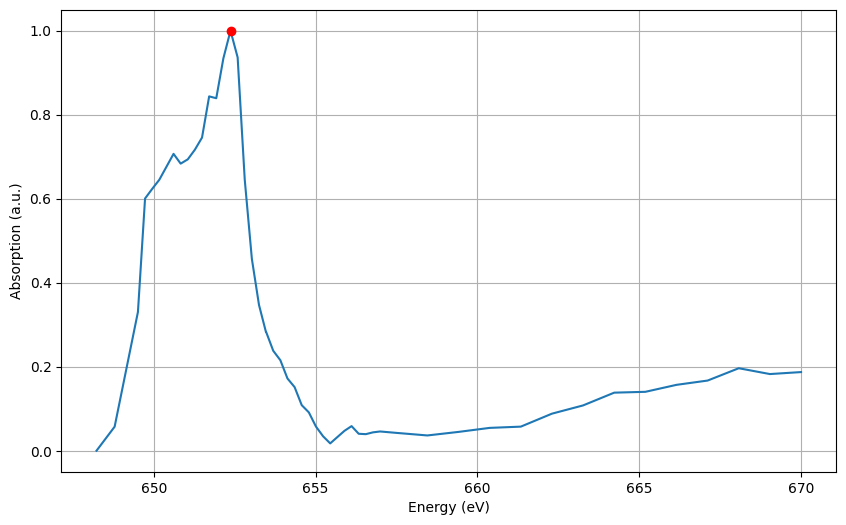

White line: 652.07


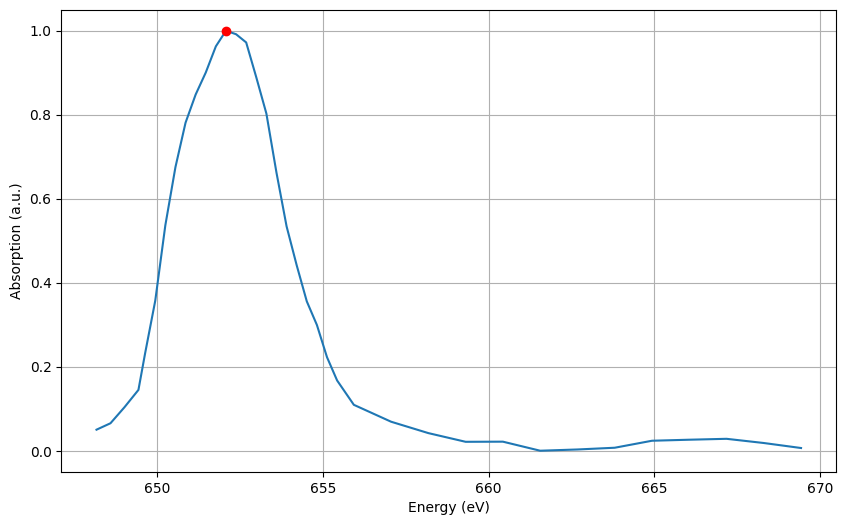

White line: 652.87


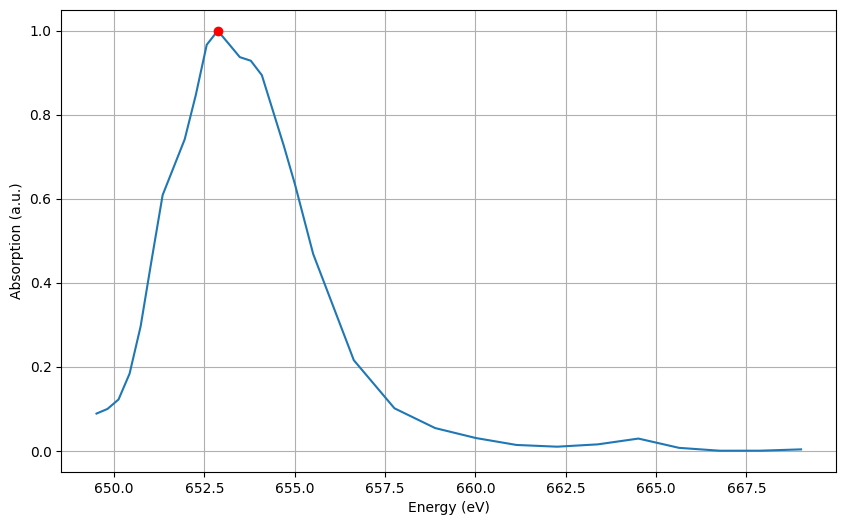

In [100]:
# Function to plot spectra and mark the absolute maximum (whiteline)
def plot_spectrum_with_whiteline(data, structure_name):
    # Extract the x and y values from the DataFrame
    x = data['x']
    y = data['y']

    # Find the index of the absolute maximum in the y column
    abs_max_index = y.idxmax()
    # Get the corresponding x and y values for the whiteline
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]
    print(f'White line: {x_abs_max}')

    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} Spectrum')
    plt.plot(x_abs_max, y_abs_max, 'ro', label='White line')  # Mark the whiteline
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.)')
  
    plt.grid(True)
    plt.show()

# Plot each spectrum with whiteline marked
plot_spectrum_with_whiteline(MnO_exp, "MnO")
plot_spectrum_with_whiteline(Mn2O3_exp, "Mn₂O₃")
plot_spectrum_with_whiteline(MnO2_exp, "MnO₂")

# **StACKING ALL EXPERIMENTAL DATA**

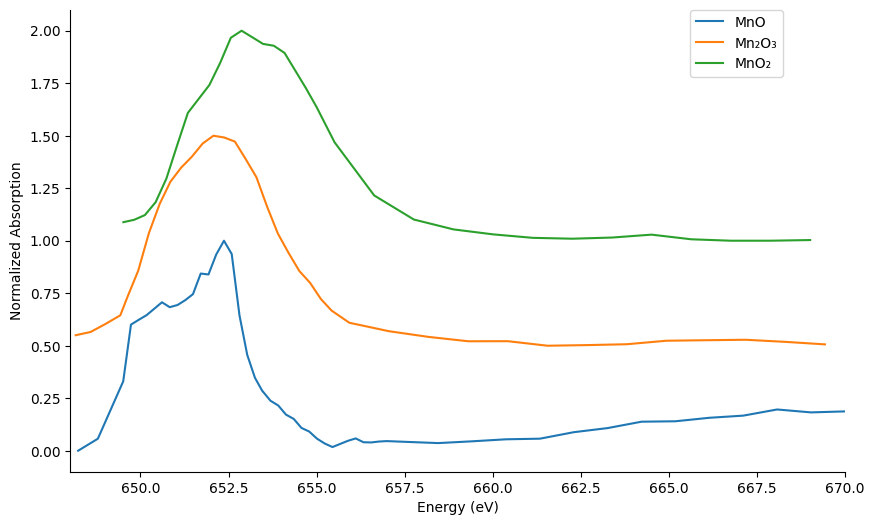

In [101]:

# Function to plot stacked XANES EXP spectra with upward shift
def plot_stacked_xanes_spectra(exp_data_list, structure_names, shift_value=0.5):
    plt.figure(figsize=(10, 6))  # Set figure size
    
    # Loop over each DFT dataset and apply an upward shift
    for i, (x, y, structure_name) in enumerate(exp_data_list):
        # Apply a shift upwards for each subsequent spectrum
        shifted_y = y + i * shift_value
        
        # Plot the spectrum with a label indicating the structure name
        plt.plot(x, shifted_y, label=f'{structure_name}')
    
    # Customize the plot
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1), borderaxespad=0)
    plt.xlim(648, 670)
    
    # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()
   
# Convert to numpy arrays for plotting
x_MnO = MnO_exp['x'].values
y_MnO = MnO_exp['y'].values

x_Mn2O3 = Mn2O3_exp['x'].values
y_Mn2O3 = Mn2O3_exp['y'].values

x_MnO2 = MnO2_exp['x'].values
y_MnO2 = MnO2_exp['y'].values

# Create a list of tuples with (x, y, structure_name) for each dataset
exp_data_list = [
    (x_MnO, y_MnO, "MnO"),
    (x_Mn2O3, y_Mn2O3, "Mn₂O₃"),
    (x_MnO2, y_MnO2, "MnO₂")
]

# Call the function to plot the stacked spectra with a shift value of 0.5
plot_stacked_xanes_spectra(exp_data_list, ["MnO", "Mn₂O₃", "MnO₂"], shift_value=0.5)


# **LOAD DFT XANES DATA FOR BULK MnOx**

In [102]:
# Load the data for MnO
MnO_data = np.loadtxt('MnO_CLN_2_CLL_1_CORE_DIELECTRIC_IMAG.dat')
MnO_DFT = pd.DataFrame(MnO_data, columns=['Energy (eV)', 'Absorption'])

# Load the data for Mn2O3
Mn2O3_data = np.loadtxt('Mn2O3_CLN2_CLL_1_CORE_DIELECTRIC_IMAG.dat')
Mn2O3_DFT = pd.DataFrame(Mn2O3_data, columns=['Energy (eV)', 'Absorption'])

# Load the data for MnO2
MnO2_data = np.loadtxt('MnO2_CLN_2_CLL_1_CORE_DIELECTRIC_IMAG.dat')
MnO2_DFT = pd.DataFrame(MnO2_data, columns=['Energy (eV)', 'Absorption'])

# # Load the data for Mn2O7
Mn2O7_data = np.loadtxt('Mn2O7_CLN2_CLL_1_CORE_DIELECTRIC_IMAG.dat')
Mn2O7_DFT = pd.DataFrame(Mn2O7_data, columns=['Energy (eV)', 'Absorption'])

MnO E₀: 629.16896504247 eV


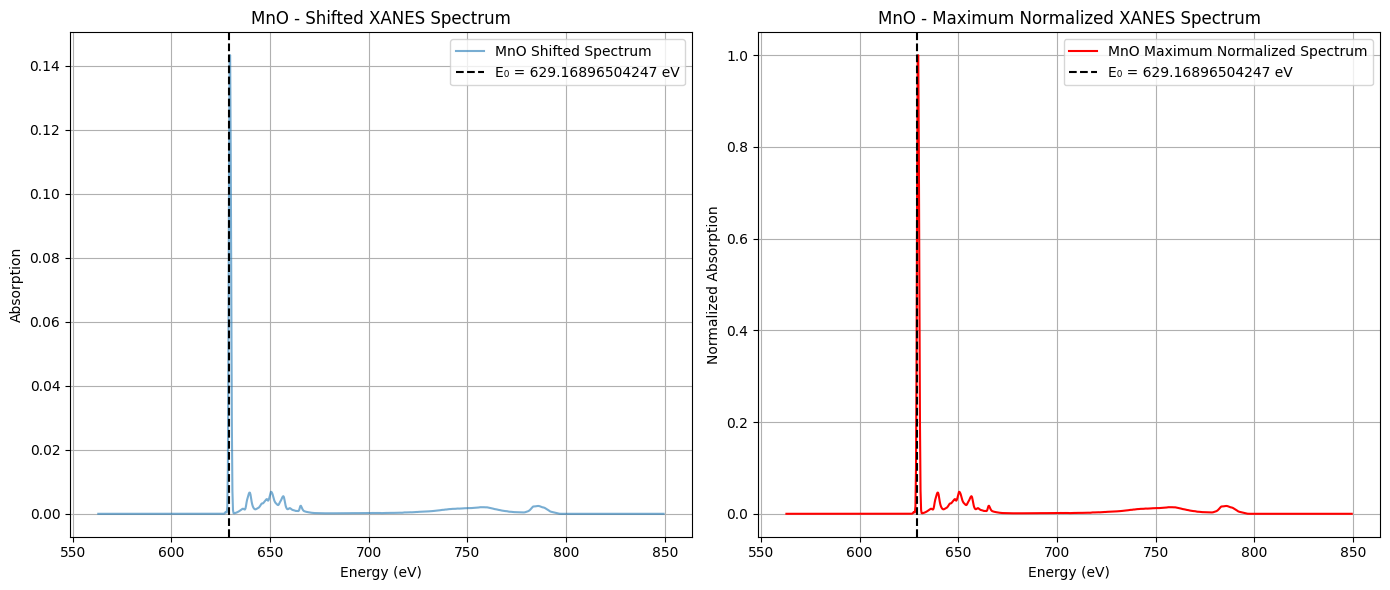

Mn2O3 E₀: 628.303333154732 eV


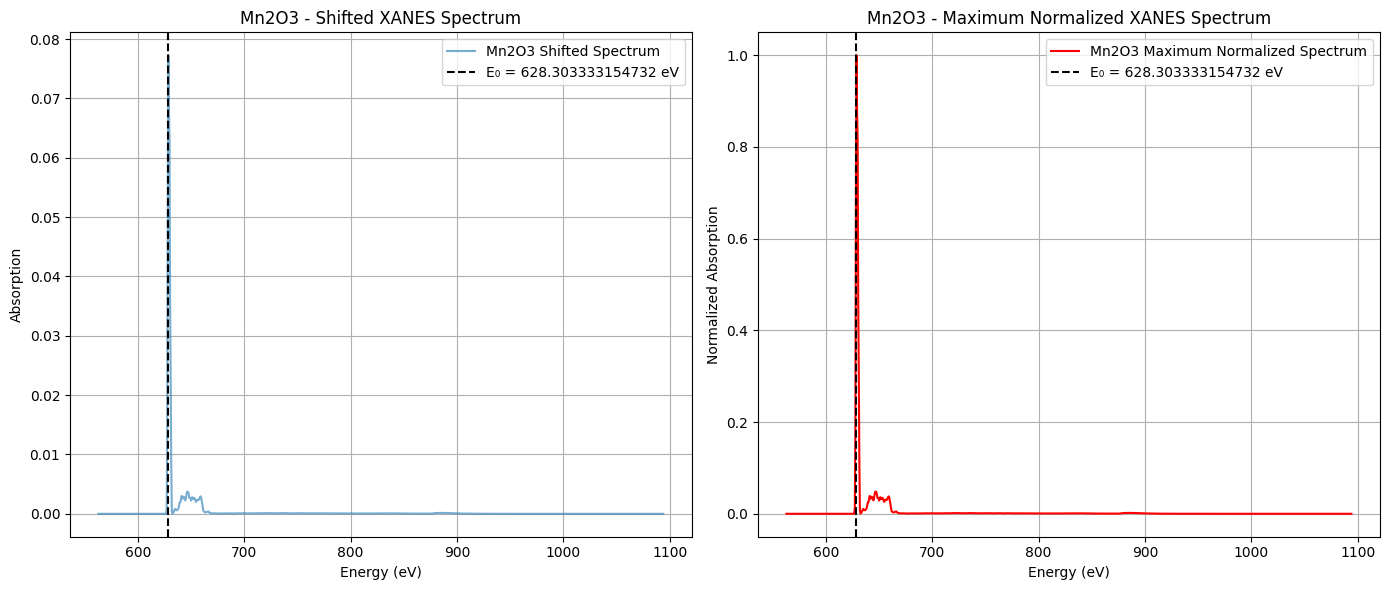

MnO2 E₀: 627.563274887049 eV


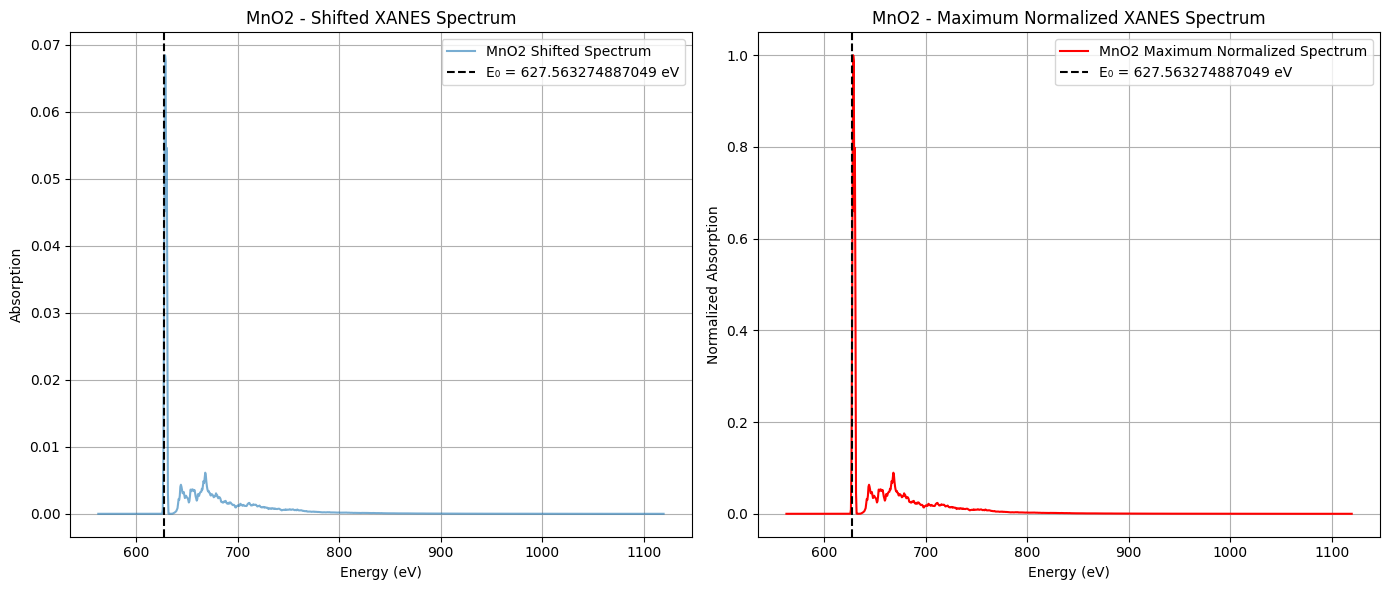

In [103]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0

# Function to shift the graph up to ensure all values are above 0
def shift_above_zero(y):
    min_y = np.min(y)
    if min_y < 0:
        # Shift the graph upwards so the minimum value becomes 0
        y_shifted = y + abs(min_y)
        return y_shifted
    return y  # If already above zero, return the original data

# Function to normalize the absorption data using maximum normalization
def normalize_max(y):
    # Normalize by dividing by the maximum value
    y_max = np.max(y)
    normalized_y = y / y_max
    return normalized_y

# Global variables for E0 values
E0_MnO_DFT = None
E0_Mn2O3_DFT = None
E0_MnO2_DFT = None

# Function to normalize and plot for each structure on separate axes
def normalize_and_plot_structure_max(x, y, structure_name):
    global E0_MnO_DFT, E0_Mn2O3_DFT, E0_MnO2_DFT  # Use global variables

    # Calculate E₀ from the first derivative
    E0 = calculate_E0(x, y)
    
    # Store E0 values in the appropriate global variable
    if structure_name == "MnO":
        E0_MnO_DFT = E0
    elif structure_name == "Mn2O3":
        E0_Mn2O3_DFT = E0
    elif structure_name == "MnO2":
        E0_MnO2_DFT = E0

    print(f"{structure_name} E₀: {E0} eV")
    
    # Shift data upwards if any values are below zero
    shifted_y = shift_above_zero(y)
    
    # Perform maximum normalization after shifting the data
    normalized_y = normalize_max(shifted_y)
    
    # Overwrite the old data with the normalized data
    if structure_name == "MnO":
        MnO_DFT['Absorption'] = normalized_y
    elif structure_name == "Mn2O3":
        Mn2O3_DFT['Absorption'] = normalized_y
    elif structure_name == "MnO2":
        MnO2_DFT['Absorption'] = normalized_y

    # Create two subplots: one for shifted and one for normalized
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the shifted spectrum on the first axis
    ax1.plot(x, shifted_y, label=f'{structure_name} Shifted Spectrum', alpha=0.6)
    ax1.axvline(E0, color='k', linestyle='--', label=f'E₀ = {E0} eV')
    ax1.set_xlabel('Energy (eV)')
    ax1.set_ylabel('Absorption')
    ax1.set_title(f'{structure_name} - Shifted XANES Spectrum')
    ax1.grid(True)
    ax1.legend()

    # Plot the normalized spectrum on the second axis
    ax2.plot(x, normalized_y, label=f'{structure_name} Maximum Normalized Spectrum', color='red')
    ax2.axvline(E0, color='k', linestyle='--', label=f'E₀ = {E0} eV')
    ax2.set_xlabel('Energy (eV)')
    ax2.set_ylabel('Normalized Absorption')
    ax2.set_title(f'{structure_name} - Maximum Normalized XANES Spectrum')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()  # Ensure proper spacing between plots
    plt.show()


# MnO
x_MnO = MnO_DFT['Energy (eV)']
y_MnO = MnO_DFT['Absorption']
normalize_and_plot_structure_max(x_MnO, y_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_DFT['Energy (eV)']
y_Mn2O3 = Mn2O3_DFT['Absorption']
normalize_and_plot_structure_max(x_Mn2O3, y_Mn2O3, "Mn2O3")

# MnO2
x_MnO2 = MnO2_DFT['Energy (eV)']
y_MnO2 = MnO2_DFT['Absorption']
normalize_and_plot_structure_max(x_MnO2, y_MnO2, "MnO2")


In [104]:
# Locate the index of the maximum Y value for the MnO experimental and DFT data
max_MnO_exp = MnO_exp['y'].idxmax()
max_MnO_DFT = MnO_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO_exp = MnO_exp.loc[max_MnO_exp, 'x']
x_max_MnO_DFT = MnO_DFT.loc[max_MnO_DFT, 'Energy (eV)']
shift_value_MnO =x_max_MnO_exp - x_max_MnO_DFT
MnO_DFT['Energy (eV)'] += shift_value_MnO

# Print the max X values
print(f'MnO_experiment max Y at Energy (eV): {x_max_MnO_exp}')
print(f'MnO_DFT max Y at Energy (eV): {x_max_MnO_DFT}')
print(f'The shift energy value for MnO2 (eV): {shift_value_MnO}')

# Locate the index of the maximum Y value for the Mn2O3 experimental and DFT data
max_Mn2O3_exp = Mn2O3_exp['y'].idxmax()
max_Mn2O3_DFT = Mn2O3_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_Mn2O3_exp = Mn2O3_exp.loc[max_Mn2O3_exp, 'x']
x_max_Mn2O3_DFT = Mn2O3_DFT.loc[max_Mn2O3_DFT, 'Energy (eV)']
shift_value_Mn2O3 =x_max_Mn2O3_exp - x_max_Mn2O3_DFT 
Mn2O3_DFT['Energy (eV)'] += shift_value_Mn2O3

# Locate the index of the maximum Y value for the MnO2 experimental and DFT data
max_MnO2_exp = MnO2_exp['y'].idxmax()
max_MnO2_DFT = MnO2_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO2_exp = MnO2_exp.loc[max_MnO2_exp, 'x']
x_max_MnO2_DFT = MnO2_DFT.loc[max_MnO2_DFT, 'Energy (eV)']
shift_value_MnO2 =x_max_MnO2_exp - x_max_MnO2_DFT 
MnO2_DFT['Energy (eV)'] += shift_value_MnO2


# Locate the index of the maximum Y value for the MnO2 experimental and DFT data
max_Mn2O7_DFT = Mn2O7_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_Mn2O7_exp = 653.1
x_max_Mn2O7_DFT = Mn2O7_DFT.loc[max_Mn2O7_DFT, 'Energy (eV)']
shift_value_Mn2O7 =x_max_Mn2O7_exp - x_max_Mn2O7_DFT 
Mn2O7_DFT['Energy (eV)'] += shift_value_Mn2O7
print(f'Mn2O7_experiment max Y at Energy (eV): {shift_value_Mn2O7}')

MnO_experiment max Y at Energy (eV): 652.37
MnO_DFT max Y at Energy (eV): 629.742464888028
The shift energy value for MnO2 (eV): 22.62753511197195
Mn2O7_experiment max Y at Energy (eV): 29.124193050515032


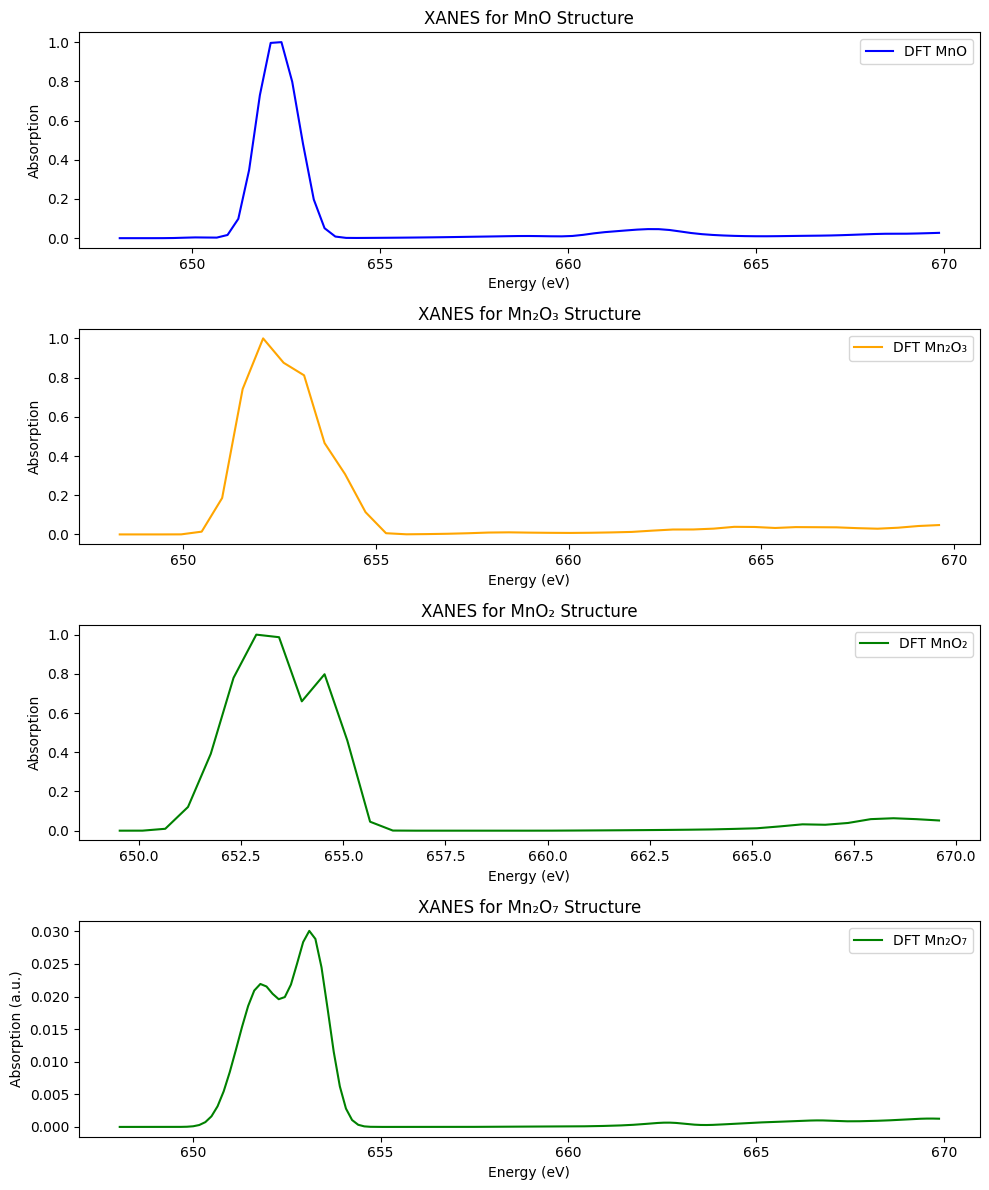

In [105]:
# Filter the DataFrame to only include rows where Energy >= 6520
MnO_DFT = MnO_DFT[(MnO_DFT["Energy (eV)"] >= 648) & (MnO_DFT["Energy (eV)"] <= 670)]
Mn2O3_DFT = Mn2O3_DFT[(Mn2O3_DFT["Energy (eV)"] >= 648) & (Mn2O3_DFT["Energy (eV)"] <= 670)]
MnO2_DFT = MnO2_DFT[(MnO2_DFT["Energy (eV)"] >= 649.3) & (MnO2_DFT["Energy (eV)"] <= 670)]
Mn2O7_DFT = Mn2O7_DFT[(Mn2O7_DFT["Energy (eV)"] >= 648) & (Mn2O7_DFT["Energy (eV)"] <= 670)]
# Create a figure with three subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))  # 3 rows, 1 column

# Plot for MnO
axs[0].plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO')
# axs[0].plot(MnO_exp['x'], MnO_exp['y'], color='red', label='Experimental MnO', alpha=0.6)  # Add experimental data
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Absorption')
axs[0].set_title('XANES for MnO Structure')

axs[0].legend()

axs[1].plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='orange', label='DFT Mn₂O₃')
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel('Absorption')
axs[1].set_title('XANES for Mn₂O₃ Structure')

axs[1].legend()

# Plot for MnO2
axs[2].plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='green', label='DFT MnO₂')
axs[2].set_xlabel('Energy (eV)')
axs[2].set_ylabel('Absorption')
axs[2].set_title('XANES for MnO₂ Structure')

axs[2].legend()

# Plot for MnO2
axs[3].plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='green', label='DFT Mn₂O₇')
axs[3].set_xlabel('Energy (eV)')
axs[3].set_ylabel('Absorption (a.u.)')
axs[3].set_title('XANES for Mn₂O₇ Structure')

axs[3].legend()

# Adjust layout to prevent overlap
axes[2].set_xlim(648, 670)
plt.tight_layout()

# Show the plots
plt.show()


# Optimising broadening factors

(σ = 1.291)


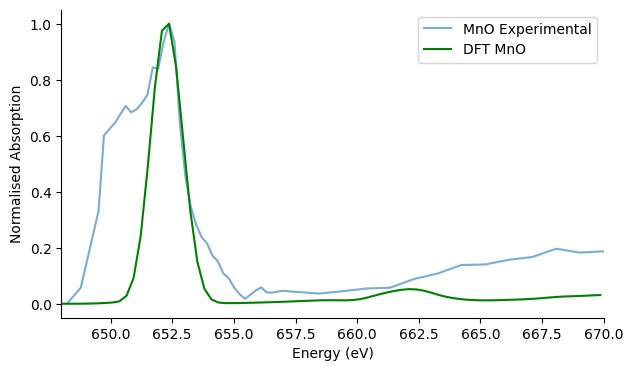

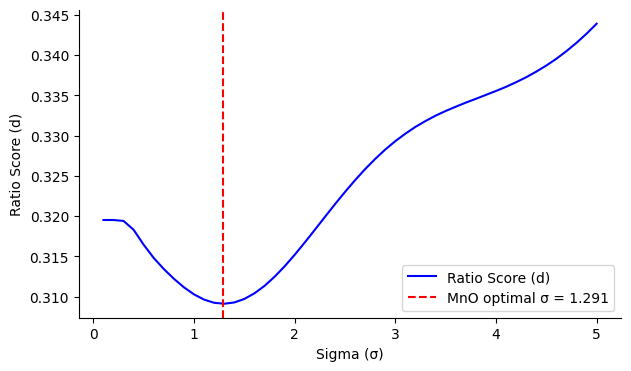

(σ = 1.918)


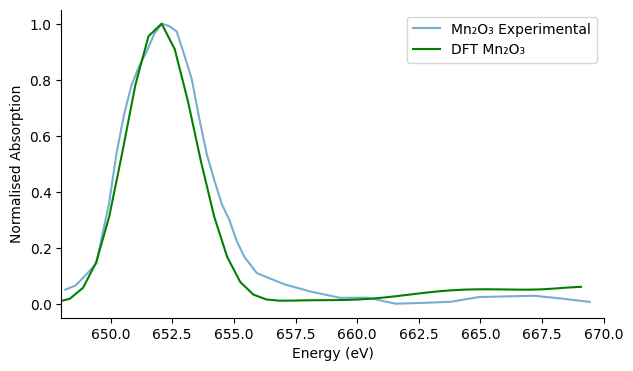

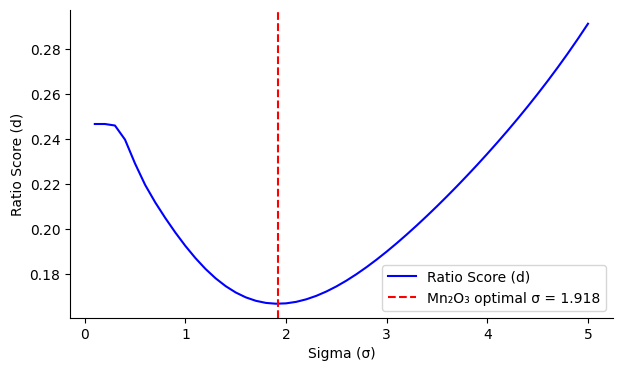

(σ = 1.704)


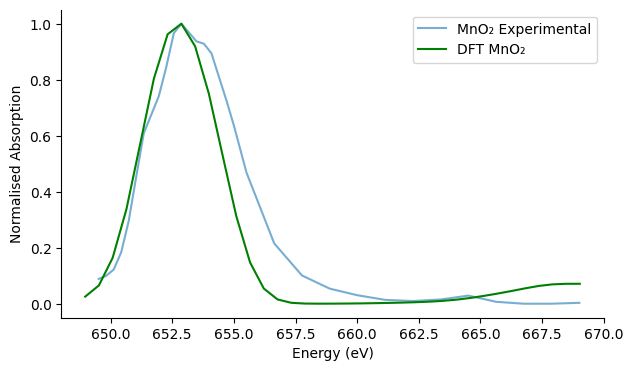

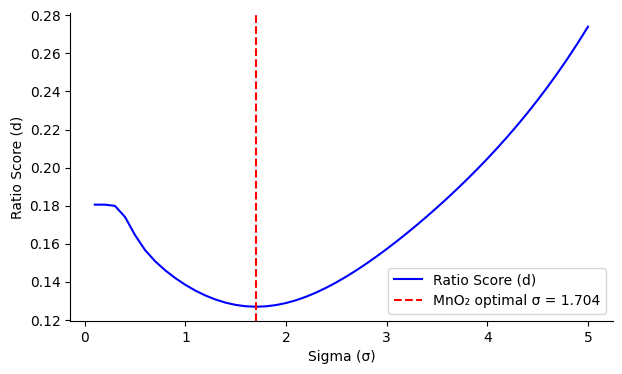

In [106]:
# Gaussian broadening function
def apply_gaussian_broadening(y_dft, sigma):
    return gaussian_filter1d(y_dft, sigma)

# Function to compute cosine similarity using gradient (slope)
def cosine_similarity_gradient(y1, y2, x):
    gradient_y1 = np.gradient(y1, x)
    gradient_y2 = np.gradient(y2, x)
    return np.dot(gradient_y1, gradient_y2) / (np.linalg.norm(gradient_y1) * np.linalg.norm(gradient_y2))

# Function to calculate RMSE (Root Mean Squared Error) using standard equation
def calculate_rmse(y1, y2):
    return np.sqrt(np.mean((y1 - y2) ** 2))

# Function to calculate the ratio score of RMSE to cosine similarity gradient
def ratio_score(sigma, x_dft, x_exp, y_exp, y_dft):
    # Apply Gaussian broadening with given sigma
    y_dft_broadened = apply_gaussian_broadening(y_dft, sigma)

    # Interpolate experimental data to match broadened DFT x-coordinates
    y_exp_interp = np.interp(x_dft, x_exp, y_exp)

    # Calculate cosine similarity gradient and RMSE
    cos_sim_gradient = cosine_similarity_gradient(y_exp_interp, y_dft_broadened, x_dft)
    rmse = calculate_rmse(y_exp_interp, y_dft_broadened)

    # Return ratio of RMSE to cosine similarity gradient (minimized by optimization)
    return rmse / cos_sim_gradient if cos_sim_gradient != 0 else np.inf

# Function to optimize sigma and plot results
def optimize_sigma(dft_df, exp_df, structure_name):
    x_dft = dft_df['Energy (eV)'].values
    y_dft = dft_df['Absorption'].values
    x_exp = exp_df['x'].values
    y_exp = exp_df['y'].values

    # Initial guess for the sigma parameter
    initial_guess = [0.5]

    # Optimize sigma to minimize RMSE / cosine similarity ratio
    result = minimize(ratio_score, initial_guess, args=(x_dft, x_exp, y_exp, y_dft), bounds=[(0.1, 5)])
    optimal_sigma = result.x[0]

    # Apply Gaussian broadening with the optimized sigma
    modified_y_dft = apply_gaussian_broadening(y_dft, optimal_sigma)

    # Normalize the modified DFT and experimental data
    renormalized_y_dft = modified_y_dft / np.max(modified_y_dft)
    renormalized_y_exp = y_exp / np.max(y_exp)
    # Get the corresponding x values for the whiteline
    # Find the index of the absolute maximum in the y column
    abs_max_index = np.argmax(renormalized_y_dft)
    abs_max_exp_index = np.argmax(renormalized_y_exp)
    x_abs_dft = x_dft[abs_max_index]
    x_abs_exp = x_exp[abs_max_exp_index]

    # Calculate the shift in x based on the whiteline positions
    x_dft_diff = x_abs_dft - x_abs_exp
    x_dft_shift = x_dft - x_dft_diff
    
    print(f'(σ = {optimal_sigma:.3f})')
    # Plot original experimental data and modified DFT data
    plt.figure(figsize=(7, 4))
    plt.plot(x_exp, renormalized_y_exp, label=f'{structure_name} Experimental', alpha=0.6)
    plt.plot(x_dft_shift, renormalized_y_dft, label=f'DFT {structure_name} ', color='green', linestyle='-')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption')
    plt.legend()
    plt.grid(False)
        # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlim(648,670)
    plt.show()

    # Generate and plot the ratio score vs sigma
    sigma_values = np.linspace(0.1, 5, 50)
    ratio_scores = [ratio_score(sigma, x_dft, x_exp, y_exp, y_dft) for sigma in sigma_values]

    plt.figure(figsize=(7, 4))
    plt.plot(sigma_values, ratio_scores, label='Ratio Score (d)', color='blue')
    plt.axvline(optimal_sigma, color='red', linestyle='--', label=f'{structure_name} optimal σ = {optimal_sigma:.3f}')
    plt.xlabel('Sigma (σ)')
    plt.ylabel('Ratio Score (d)')
    plt.legend()
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    # Update DFT absorption data in DataFrame for final plot
    dft_df['Absorption'] = renormalized_y_dft
    dft_df['Energy (eV)'] = x_dft_shift
    exp_df['y'] = renormalized_y_exp

# Apply optimization to all structures
optimize_sigma(MnO_DFT, MnO_exp, "MnO")
optimize_sigma(Mn2O3_DFT, Mn2O3_exp, "Mn₂O₃")
optimize_sigma(MnO2_DFT, MnO2_exp, "MnO₂")

# **PLOTTING Mn₂O₇ WITH AVG SIGMA**

σ = 1.640


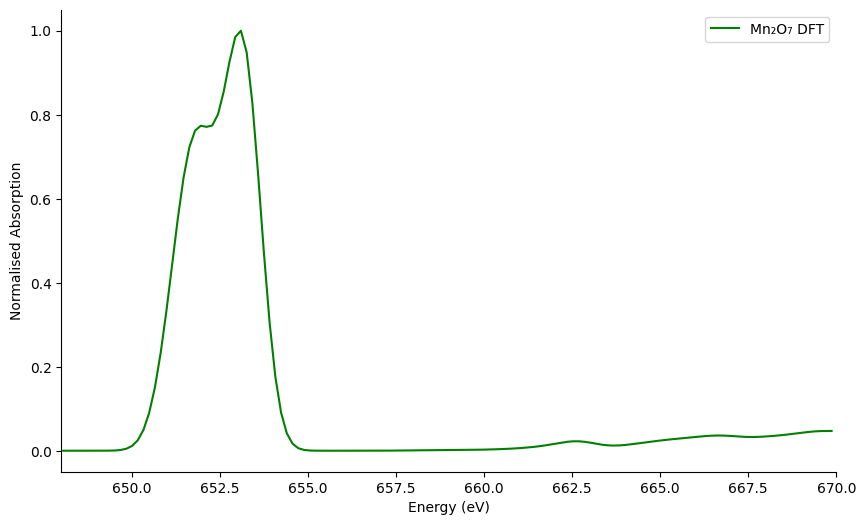

In [107]:
# Function for applying Gaussian broadening
def apply_gaussian_broadening(y_dft, sigma):
    return gaussian_filter1d(y_dft, sigma)

# Apply Gaussian broadening with a given sigma
def apply_broadening_to_Mn2O7(dft_df, sigma_avg):
    x_dft = dft_df['Energy (eV)'].values
    y_dft = dft_df['Absorption'].values
    
    # Normalize the original DFT absorption spectrum
    y_dft /= np.max(y_dft)

    # Apply Gaussian broadening
    y_dft_broadened = apply_gaussian_broadening(y_dft, sigma_avg)

    # Normalize the broadened DFT absorption data
    renormalized_y_dft = y_dft_broadened / np.max(y_dft_broadened)
    print(f'σ = {sigma_avg:.3f}')
    # Plot the broadened DFT data
    plt.figure(figsize=(10, 6))
    plt.plot(x_dft, renormalized_y_dft, label=f'Mn₂O₇ DFT', color='green')
    # plt.plot(Mn2O7_exp['x'], Mn2O7_exp['y'], label='experiment', color='blue', linewidth=2)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption')
    plt.legend()
        # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlim(648,670)
    plt.show()
    plt.show()
 
    dft_df['Absorption'] = renormalized_y_dft

# Compute average sigma from previous results
sigma_avg = 1.64  # Replace these values with actual optimized sigma values

# Apply the broadening to Mn2O7 DFT data
apply_broadening_to_Mn2O7(Mn2O7_DFT, sigma_avg)


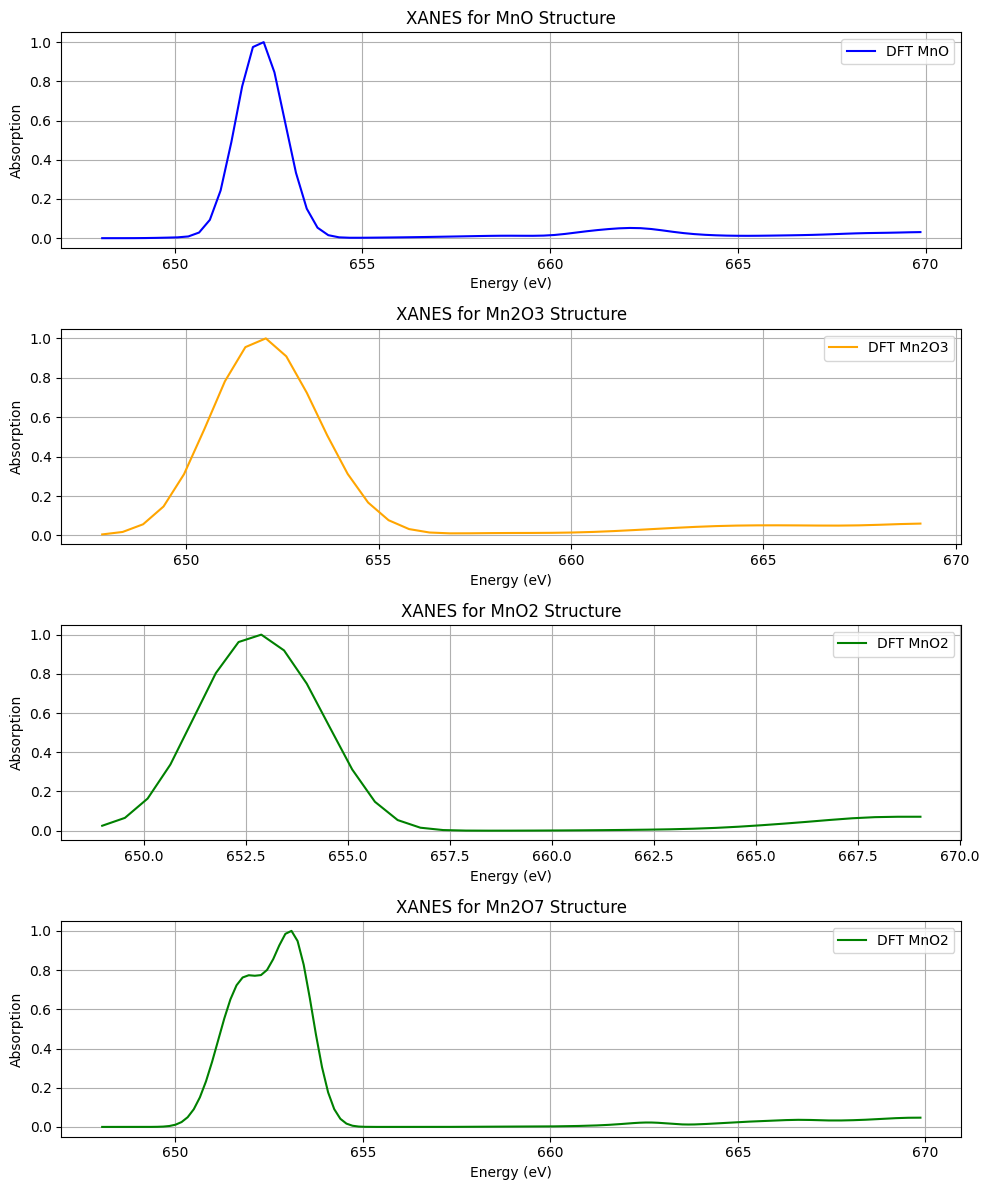

In [108]:
# Create a figure with three subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))  # 3 rows, 1 column

# Plot for MnO
axs[0].plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO')
# axs[0].plot(MnO_exp['x'], MnO_exp['y'], color='red', label='Experimental MnO', alpha=0.6)  # Add experimental data
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Absorption')
axs[0].set_title('XANES for MnO Structure')
axs[0].grid(True)
axs[0].legend()

# Plot for Mn2O3
axs[1].plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='orange', label='DFT Mn2O3')
# axs[1].plot(Mn2O3_exp['x'], Mn2O3_exp['y'], color='red', label='Experimental Mn2O3', alpha=0.6)  # Add experimental data
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel('Absorption')
axs[1].set_title('XANES for Mn2O3 Structure')
axs[1].grid(True)
axs[1].legend()

# Plot for MnO2
axs[2].plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='green', label='DFT MnO2')
# axs[2].plot(MnO2_exp['x'], MnO2_exp['y'], color='red', label='Experimental MnO2', alpha=0.6)  # Add experimental data
axs[2].set_xlabel('Energy (eV)')
axs[2].set_ylabel('Absorption')
axs[2].set_title('XANES for MnO2 Structure')
axs[2].grid(True)
axs[2].legend()

# Plot for MnO2
axs[3].plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='green', label='DFT MnO2')
# axs[2].plot(MnO2_exp['x'], MnO2_exp['y'], color='red', label='Experimental MnO2', alpha=0.6)  # Add experimental data
axs[3].set_xlabel('Energy (eV)')
axs[3].set_ylabel('Absorption')
axs[3].set_title('XANES for Mn2O7 Structure')
axs[3].grid(True)
axs[3].legend()

# Adjust layout to prevent overlap
axes[2].set_xlim(630, 670)
plt.tight_layout()

# Show the plots
plt.show()


# **EXTRACTING E₀ & SHOULDERS**

MnO error level: 0.2450
 MnO potential shoulder: x = 651.80, y = 0.7742


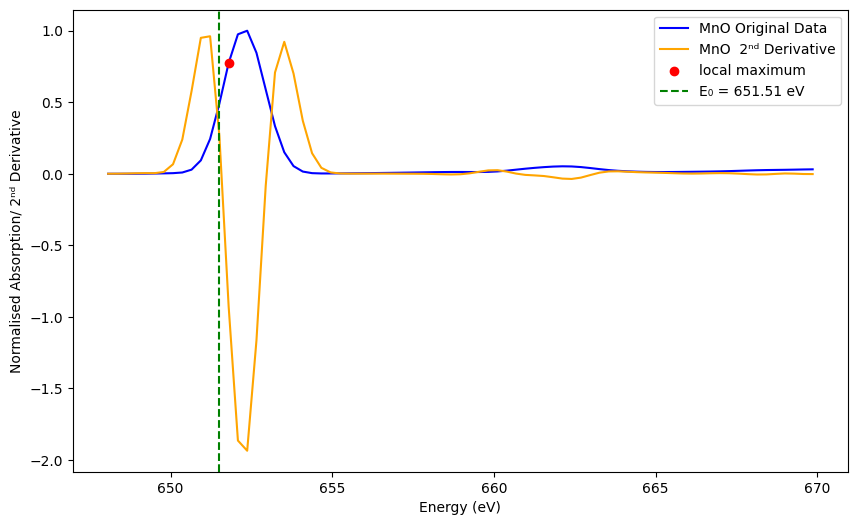

Mn₂O₃ error level: 0.1665
 Mn₂O₃ potential shoulder: x = 651.54, y = 0.9556


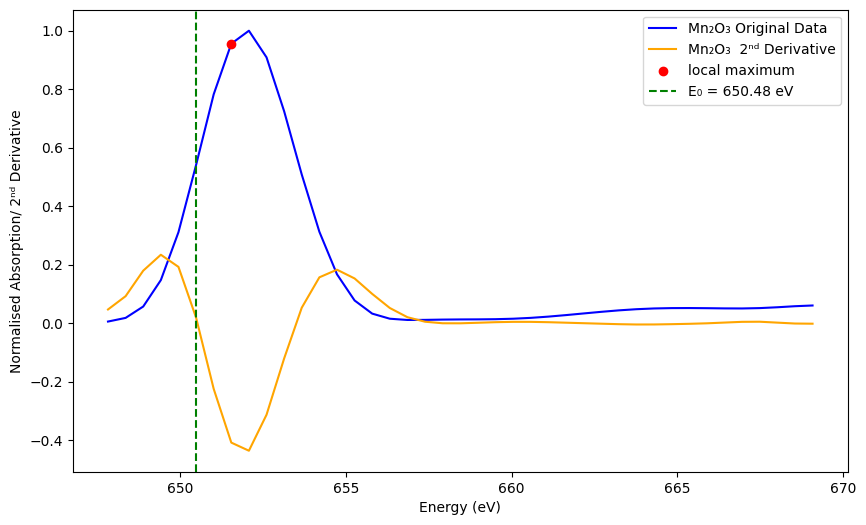

MnO₂ error level: 0.1693
 MnO₂ potential shoulder: x = 652.31, y = 0.9623


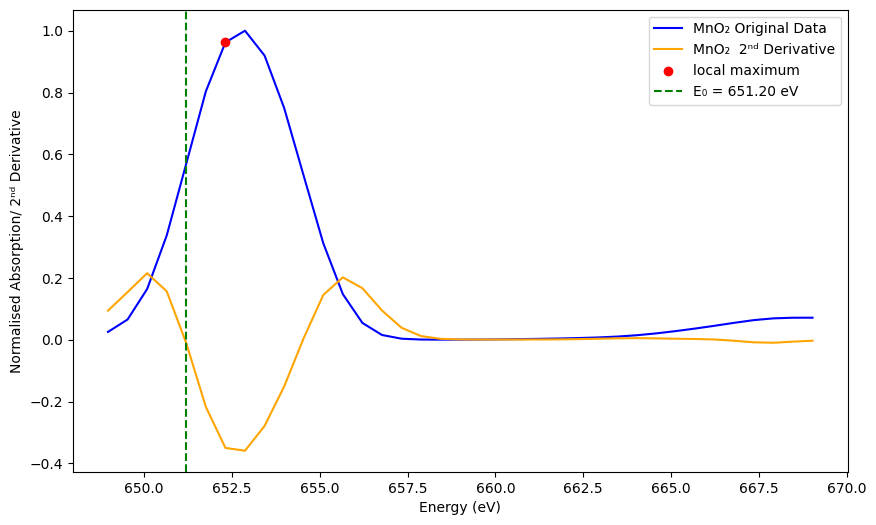

Mn₂O₇ error level: 0.2394
 Mn₂O₇ potential shoulder: x = 651.63, y = 0.7225


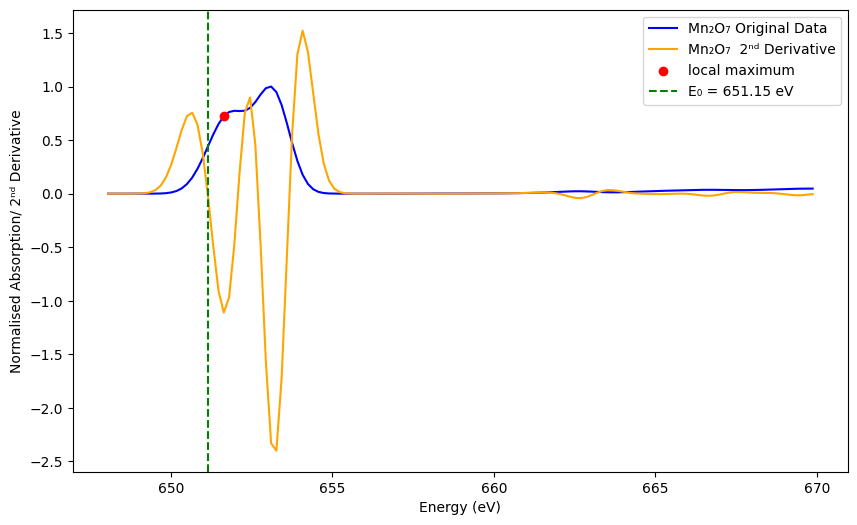

In [109]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Find the white line position (where y is maximum)
    white_line = x[np.argmax(y)]*.9995
    
    # Restrict to pre-edge region (between E₀ and white_line)
    pre_edge_mask = (x > E0) & (x < white_line)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    pre_edge_y = y[pre_edge_mask]

    # Find the true minimum point in the pre-edge region of the second derivative
    if len(pre_edge_x) > 0:
        min_index = np.argmin(pre_edge_d2y_dx2)
        x_min = pre_edge_x[min_index]
        y_min = pre_edge_y[min_index]

        # Display the minimum x and y values
     
        print(f" {structure_name} potential shoulder: x = {x_min:.2f}, y = {y_min:.4f}")
    else:
        print(f"No valid pre-edge region found for {structure_name} between E₀ and the white line.")

    # Plot the original data, the second derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} Original Data', color='blue')
    
    # Plot the second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name}  2ⁿᵈ Derivative', color='orange')
    
    # Mark the minimum point if found
    if len(pre_edge_x) > 0:
        plt.scatter(x_min, y_min, color='red', label='local maximum', zorder=5)
    # plt.title(f'{structure_name}: Original Data, 2nd Derivative, and Pre-Edge Minimum')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption/ 2ⁿᵈ Derivative')
    plt.axvline(E0, color='green', linestyle='--', label=f'E₀ = {E0:.2f} eV')
    plt.legend()
    plt.show()

# MnO
x_MnO = MnO_DFT['Energy (eV)'].values
y_MnO = MnO_DFT['Absorption'].values
E0_MnO, _ = calculate_E0(x_MnO, y_MnO)
find_pre_edge_minima(x_MnO, y_MnO, E0_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_DFT['Energy (eV)'].values
y_Mn2O3 = Mn2O3_DFT['Absorption'].values
E0_Mn2O3, _ = calculate_E0(x_Mn2O3, y_Mn2O3)
find_pre_edge_minima(x_Mn2O3, y_Mn2O3, E0_Mn2O3, "Mn₂O₃")

# MnO2
x_MnO2 = MnO2_DFT['Energy (eV)'].values
y_MnO2 = MnO2_DFT['Absorption'].values
E0_MnO2, _ = calculate_E0(x_MnO2, y_MnO2)
find_pre_edge_minima(x_MnO2, y_MnO2, E0_MnO2, "MnO₂")
# MnO2
x_Mn2O7 = Mn2O7_DFT['Energy (eV)'].values
y_Mn2O7 = Mn2O7_DFT['Absorption'].values
E0_Mn2O7, _ = calculate_E0(x_Mn2O7, y_Mn2O7)
find_pre_edge_minima(x_Mn2O7, y_Mn2O7, E0_Mn2O7, "Mn₂O₇")

# **WHITE-LINE**

white line: 652.37 eV


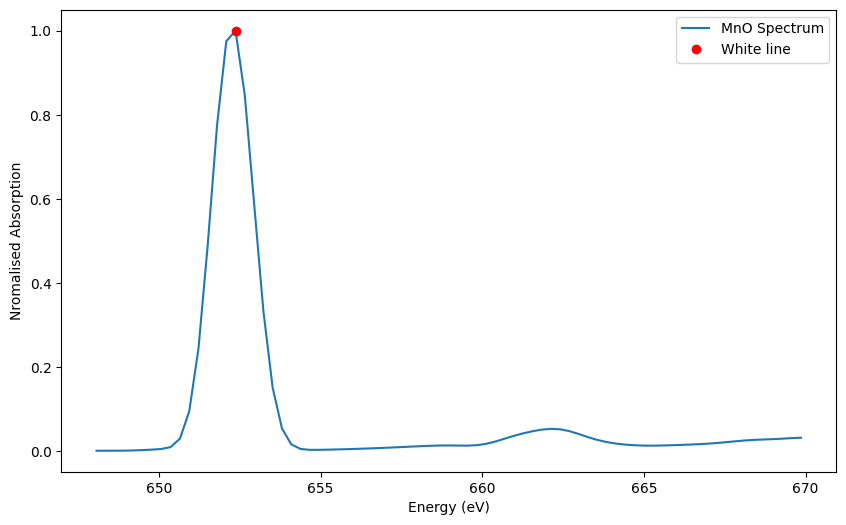

white line: 652.07 eV


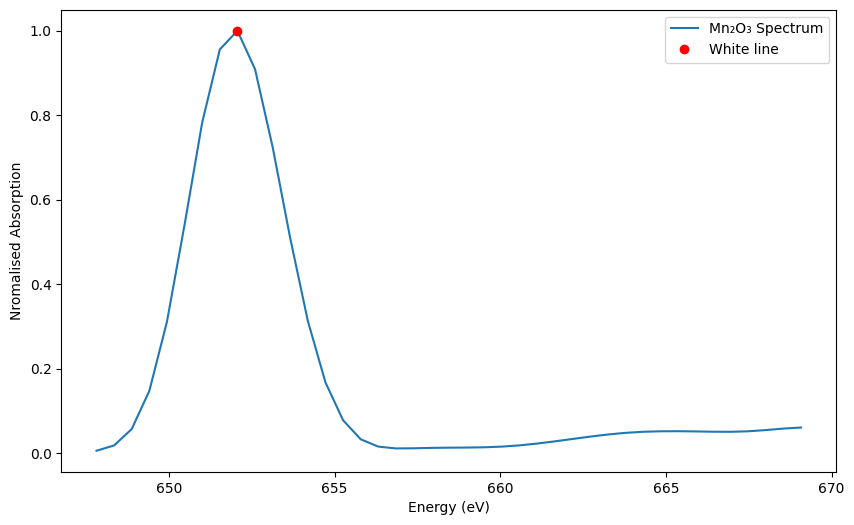

white line: 652.87 eV


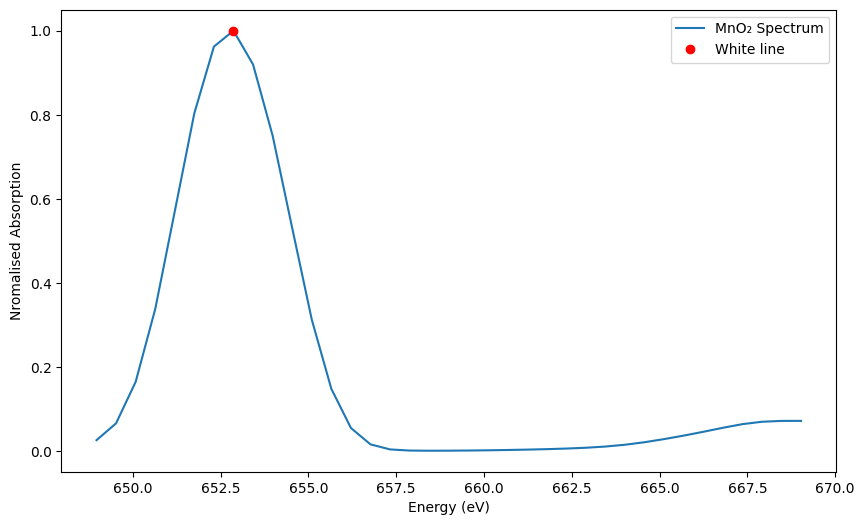

white line: 653.1 eV


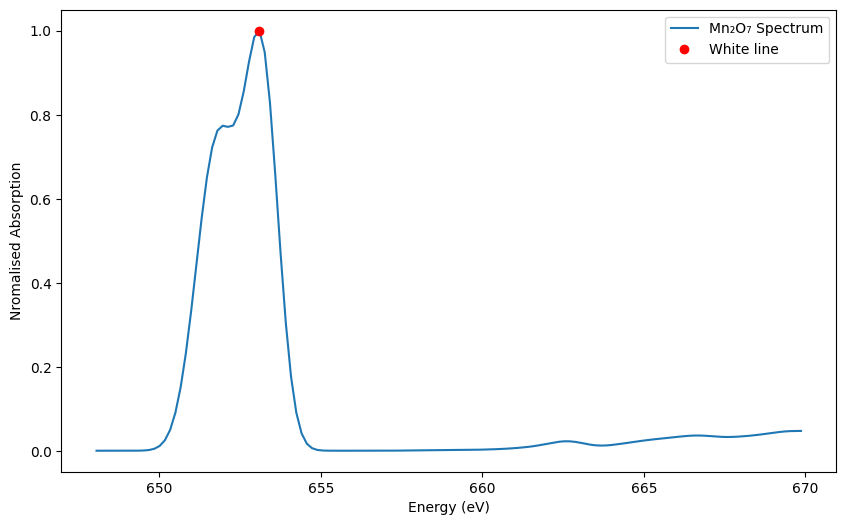

In [110]:
# Function to plot spectra and mark the absolute maximum (whiteline)
def plot_spectrum_with_whiteline(data, structure_name):
    # Extract the x and y values from the DataFrame
    x = data['Energy (eV)']
    y = data['Absorption']

    # Find the index of the absolute maximum in the y column
    abs_max_index = y.idxmax()
    # Get the corresponding x and y values for the whiteline
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]
    print(f'white line: {x_abs_max} eV')

    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} Spectrum')
    plt.plot(x_abs_max, y_abs_max, 'ro', label='White line') 
    plt.xlabel('Energy (eV)')
    plt.ylabel('Nromalised Absorption')
    plt.legend()
    plt.show()

# Plot each spectrum with whiteline marked
plot_spectrum_with_whiteline(MnO_DFT, "MnO")
plot_spectrum_with_whiteline(Mn2O3_DFT, "Mn₂O₃")
plot_spectrum_with_whiteline(MnO2_DFT, "MnO₂")
plot_spectrum_with_whiteline(Mn2O7_DFT, "Mn₂O₇")

# **FIRST MAXIMUM POST-EDGE**

White-line: 652.37 eV
Local maxima in first derivative (x < white-line): [651.50975023]
MnO ring error level: 0.2450
Local minima in second derivative (x > white line) for MnO ring:
  x = 655.81, y = 0.0009
  x = 658.68, y = -0.0050
  x = 662.41, y = -0.0363
  x = 666.13, y = 0.0011
  x = 668.14, y = -0.0052


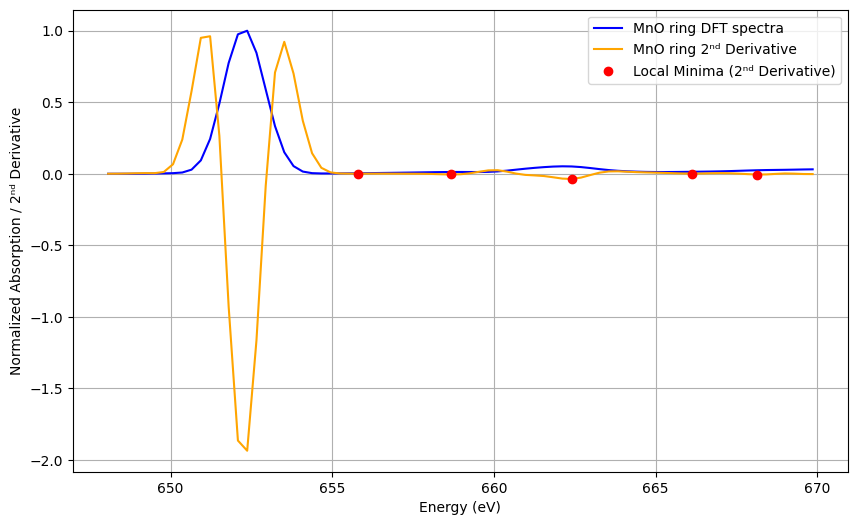

White-line: 652.07 eV
Local maxima in first derivative (x < white-line): [650.47552194]
Mn2O3 error level: 0.1665
Local minima in second derivative (x > white line) for Mn2O3:
  x = 658.45, y = -0.0006
  x = 663.76, y = -0.0046


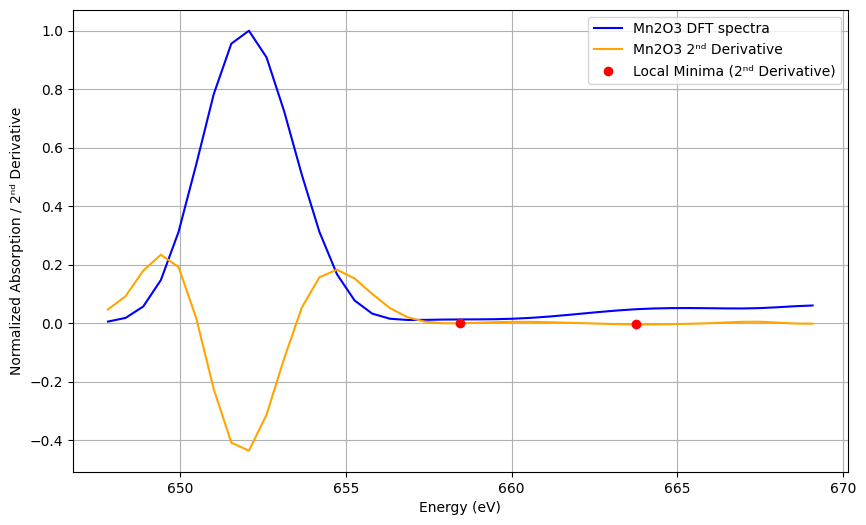

White-line: 652.87 eV
Local maxima in first derivative (x < white-line): [651.19844288]
MnO2 error level: 0.1693
Local minima in second derivative (x > white line) for MnO2:
  x = 660.67, y = 0.0006
  x = 667.91, y = -0.0099


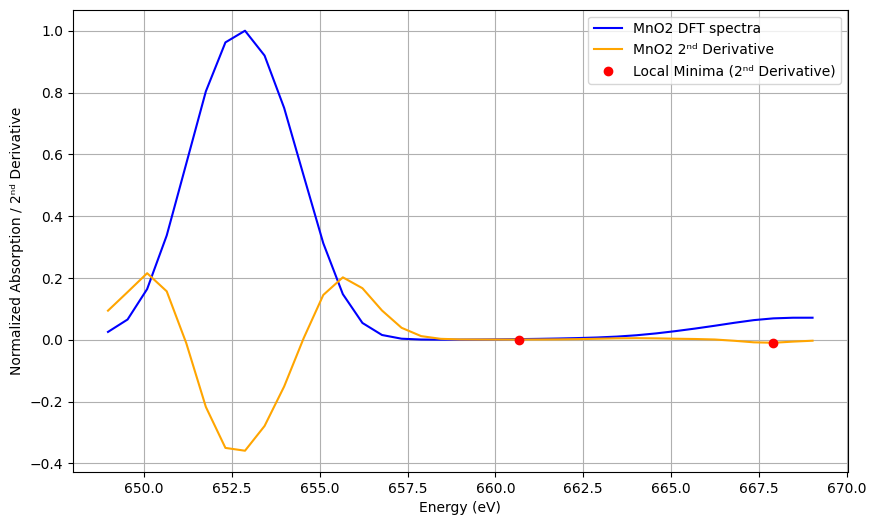

White-line: 653.1 eV
Local maxima in first derivative (x < white-line): [651.14652563 652.77442094]
Mn2O7 error level: 0.2394
Local minima in second derivative (x > white line) for Mn2O7:
  x = 656.03, y = 0.0000
  x = 658.31, y = -0.0006
  x = 662.70, y = -0.0412
  x = 665.15, y = -0.0045
  x = 666.61, y = -0.0197
  x = 669.38, y = -0.0154


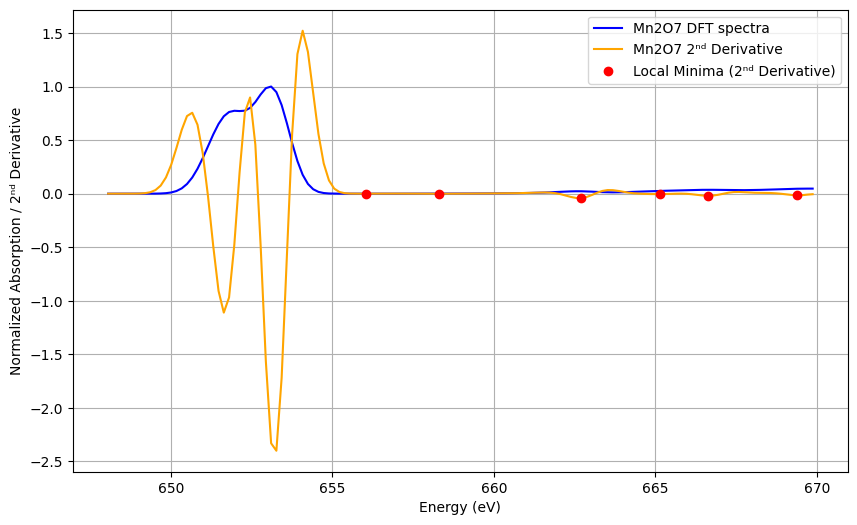

In [111]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for x > white line
def find_post_white_line_minima(x, y, x_white_line, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Restrict the search to x > white line
    post_white_line_mask = (x > x_white_line)
    post_white_line_x = x[post_white_line_mask]
    post_white_line_d2y_dx2 = d2y_dx2[post_white_line_mask]
    
    # Find local minima (peaks of -d2y_dx2) in the second derivative for x > white line
    minima_indices, _ = find_peaks(-post_white_line_d2y_dx2)
    local_minima_x = post_white_line_x[minima_indices]
    local_minima_y = post_white_line_d2y_dx2[minima_indices]
    
    # Display the minima x-values and corresponding y-values
    print(f"Local minima in second derivative (x > white line) for {structure_name}:")
    for x_min, y_min in zip(local_minima_x, local_minima_y):
        print(f"  x = {x_min:.2f}, y = {y_min:.4f}")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Plot original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    
    # Plot second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    
    # Mark the minima points on the second derivative graph
    plt.scatter(local_minima_x, local_minima_y, color='red', label='Local Minima (2ⁿᵈ Derivative)', zorder=5)
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white-line and local maxima in the first derivative
def find_white_line_and_local_maxima_and_minima(x, y, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the white-line maximum in the original spectrum
    abs_max_index = y.argmax()
    x_white_line = x[abs_max_index]
    y_white_line = y[abs_max_index]
    print(f'White-line: {x_white_line} eV')
    
    # Restrict to x < white line for local maxima in first derivative
    mask = x < x_white_line
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]
    
    # Find local maxima in the first derivative where x < white line
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
    
    print("Local maxima in first derivative (x < white-line):", local_maxima_x)
    
    # Call function to find local minima in second derivative where x > white line
    find_post_white_line_minima(x, y, x_white_line, structure_name)

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Analysis for each structure
# MnO ring
x_MnO_DFT, y_MnO_DFT = extract_data(MnO_DFT, "MnO")
if x_MnO_DFT is not None and y_MnO_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_DFT, y_MnO_DFT, "MnO ring")

# MnO string
x_Mn2O3_DFT, y_Mn2O3_DFT= extract_data(Mn2O3_DFT, "Mn2O3")
if x_Mn2O3_DFT is not None and y_Mn2O3_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_Mn2O3_DFT, y_Mn2O3_DFT, "Mn2O3")

# OMnO
x_MnO2_DFT, y_MnO2_DFT = extract_data(MnO2_DFT, "MnO2")
if x_MnO2_DFT is not None and y_MnO2_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO2_DFT, y_MnO2_DFT, "MnO2")

# OMnOMnO
x_Mn2O7_DFT, y_Mn2O7_DFT = extract_data(Mn2O7_DFT, "Mn2O7")
if x_Mn2O7_DFT is not None and y_Mn2O7_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_Mn2O7_DFT, y_Mn2O7_DFT, "Mn2O7")


# **STACKING ALL DFT DATA**

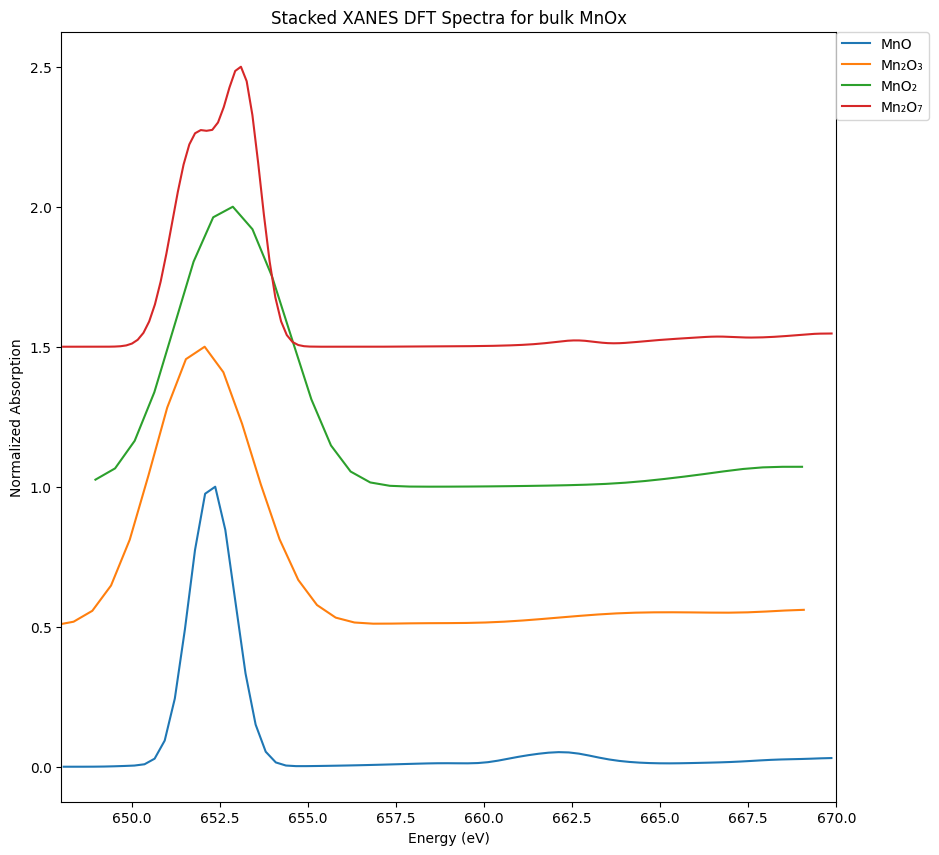

In [112]:
# Function to plot stacked XANES DFT spectra with upward shift
def plot_stacked_xanes_spectra(dft_data_list, structure_names, shift_value=1):
    plt.figure(figsize=(10, 10))  # Set figure size
    
    # Loop over each DFT dataset and apply an upward shift
    for i, (x, y, structure_name) in enumerate(dft_data_list):
        # Apply a shift upwards for each subsequent spectrum
        shifted_y = y + i * shift_value
        
        # Plot the spectrum with a label indicating the structure name
        plt.plot(x, shifted_y, label=f'{structure_name}')
    
    # Customize the plot
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    plt.title('Stacked XANES DFT Spectra for bulk MnOx')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
    plt.xlim(648,670)
    plt.show()


# Convert to numpy arrays for plotting
x_MnO = MnO_DFT['Energy (eV)'].values
y_MnO = MnO_DFT['Absorption'].values

x_Mn2O3 = Mn2O3_DFT['Energy (eV)'].values
y_Mn2O3 = Mn2O3_DFT['Absorption'].values

x_MnO2 = MnO2_DFT['Energy (eV)'].values
y_MnO2 = MnO2_DFT['Absorption'].values

x_Mn2O7 = Mn2O7_DFT['Energy (eV)'].values
y_Mn2O7 = Mn2O7_DFT['Absorption'].values

# Create a list of tuples with (x, y, structure_name) for each dataset
dft_data_list = [
    (x_MnO, y_MnO, "MnO"),
    (x_Mn2O3, y_Mn2O3, "Mn₂O₃"),
    (x_MnO2, y_MnO2, "MnO₂"),
    (x_Mn2O7, y_Mn2O7, "Mn₂O₇")
]

# Call the function to plot the stacked spectra with a shift value of 0.5 (you can adjust this)
plot_stacked_xanes_spectra(dft_data_list, ["MnO", "Mn₂O₃", "MnO₂", "Mn₂O₇"], shift_value=0.5)

# **LOADING Co-Mn DATA**

In [113]:
# Load the data for MnO
MnO_ring= np.loadtxt('MnO_ring_L2_CORE_DIELECTRIC_IMAG.dat')
MnO_ring = pd.DataFrame(MnO_ring, columns=['Energy (eV)', 'Absorption'])

# Load the data for Mn2O3
MnO_string = np.loadtxt('MnO_string_Ledge_L2_CORE_DIELECTRIC_IMAG.dat')
MnO_string = pd.DataFrame(MnO_string, columns=['Energy (eV)', 'Absorption'])

# Load the data for MnO2
OMnO_Ledge= np.loadtxt('MnO2_Ledge_L2_CORE_DIELECTRIC_IMAG.dat')
OMnO_Ledge = pd.DataFrame(OMnO_Ledge, columns=['Energy (eV)', 'Absorption'])

# Load the data for Mn2O7
OMnOMnO = np.loadtxt('OMnOMnO_L2_CORE_DIELECTRIC_IMAG.dat')
OMnOMnO = pd.DataFrame(OMnOMnO, columns=['Energy (eV)', 'Absorption'])

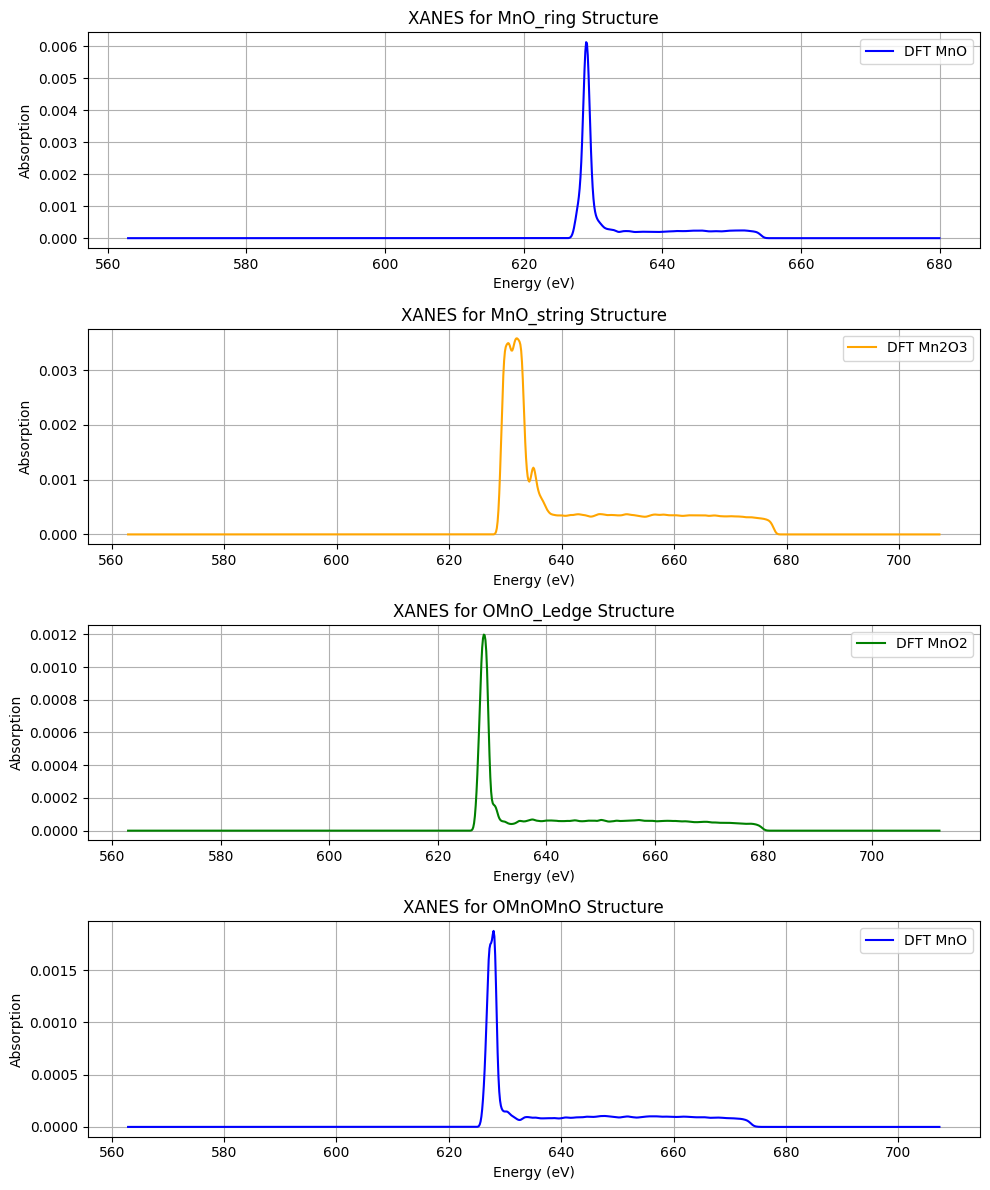

In [114]:
# Create a figure with three subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))  # 3 rows, 1 column

# Plot for MnO
axs[0].plot(MnO_ring["Energy (eV)"], MnO_ring['Absorption'], color='blue', label='DFT MnO')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Absorption')
axs[0].set_title('XANES for MnO_ring Structure')
axs[0].grid(True)
axs[0].legend()

# Plot for Mn2O3
axs[1].plot(MnO_string["Energy (eV)"], MnO_string['Absorption'], color='orange', label='DFT Mn2O3')
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel('Absorption')
axs[1].set_title('XANES for MnO_string Structure')
axs[1].grid(True)
axs[1].legend()

# Plot for MnO2
axs[2].plot(OMnO_Ledge["Energy (eV)"], OMnO_Ledge['Absorption'], color='green', label='DFT MnO2')
axs[2].set_xlabel('Energy (eV)')
axs[2].set_ylabel('Absorption')
axs[2].set_title('XANES for OMnO_Ledge Structure')
axs[2].grid(True)
axs[2].legend()

axs[3].plot(OMnOMnO["Energy (eV)"], OMnOMnO['Absorption'], color='blue', label='DFT MnO')
axs[3].set_xlabel('Energy (eV)')
axs[3].set_ylabel('Absorption')
axs[3].set_title('XANES for OMnOMnO Structure')
axs[3].grid(True)
axs[3].legend()


# Adjust layout to prevent overlap
axes[2].set_xlim(630, 670)
plt.tight_layout()

# Show the plots
plt.show()

# Shifting Co-Mn spectra based on MnO whiteline

In [115]:
# Locate the index of the maximum Y value for the MnO experimental and DFT data
max_MnO_ring = MnO_ring['Absorption'].idxmax()

# Find the corresponding X values
MnO_ring_whiteline = 652.37
x_MnO_ring = MnO_ring.loc[max_MnO_ring, 'Energy (eV)']
shift_MnO_ring = MnO_ring_whiteline - x_MnO_ring
MnO_ring['Energy (eV)'] += shift_MnO_ring

# Load
max_MnO_string = MnO_string['Absorption'].idxmax()

# Find the corresponding X values
MnO_string_whiteline = 652.37
x_MnO_string = MnO_string.loc[max_MnO_string, 'Energy (eV)']
shift_MnO_string = MnO_string_whiteline - x_MnO_string
MnO_string['Energy (eV)'] += shift_MnO_string

# Load
max_OMnO_struct = OMnO_Ledge['Absorption'].idxmax()

# Find the corresponding X values
OMnO_struct_whiteline = 652.37
x_OMnO_struct = OMnO_Ledge.loc[max_OMnO_struct, 'Energy (eV)']
shift_OMnO_struct = OMnO_struct_whiteline - x_OMnO_struct
OMnO_Ledge['Energy (eV)'] += shift_OMnO_struct

# Load
max_OMnOMnO_struct = OMnOMnO['Absorption'].idxmax()

# Find the corresponding X values
OMnOMnO_struct_whiteline = 652.37
x_OMnOMnO_struct = OMnOMnO.loc[max_OMnOMnO_struct, 'Energy (eV)']
shift_OMnOMnO_struct = OMnOMnO_struct_whiteline - x_OMnOMnO_struct
OMnOMnO['Energy (eV)'] += shift_OMnOMnO_struct

In [116]:
# Filter the DataFrame to only include rows where Energy >= 6520
MnO_ring = MnO_ring[(MnO_ring["Energy (eV)"] >= 648) & (MnO_ring["Energy (eV)"] <= 670)]
MnO_string = MnO_string[(MnO_string["Energy (eV)"] >= 648) & (MnO_string["Energy (eV)"] <= 670)]
OMnO_Ledge = OMnO_Ledge[(OMnO_Ledge["Energy (eV)"] >= 648) & (OMnO_Ledge["Energy (eV)"] <= 670)]
OMnOMnO    = OMnOMnO[(OMnOMnO["Energy (eV)"] >= 648) & (OMnOMnO["Energy (eV)"] <= 670)]

# **CHECKING FOR PRE-EDGE IN DFT**

MnO ring error level: 0.0016
Minimum in pre-edge region for MnO ring:
  Minimum: x = 648.04, y = 0.0000


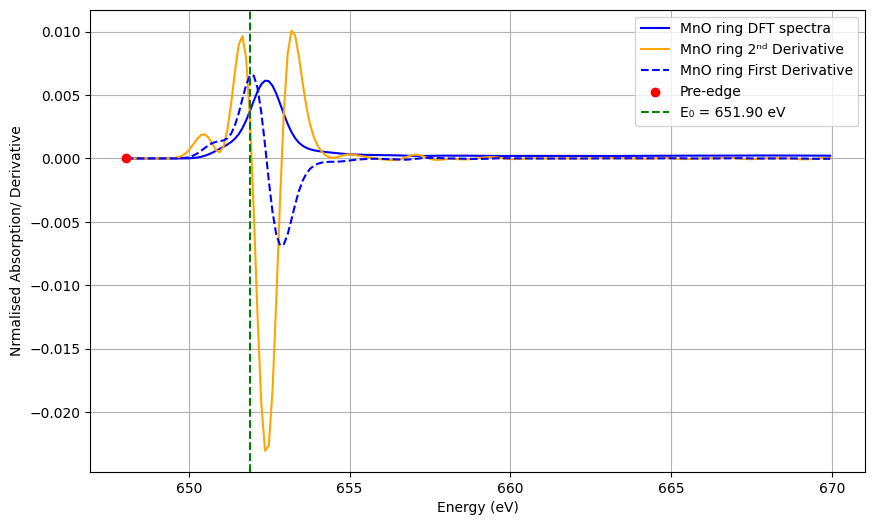

White-line: 652.37 eV
Local maxima in first derivative (x < white-line): [651.90136525]
MnO string error level: 0.0008
Minimum in pre-edge region for MnO string:
  Minimum: x = 648.04, y = 0.0000


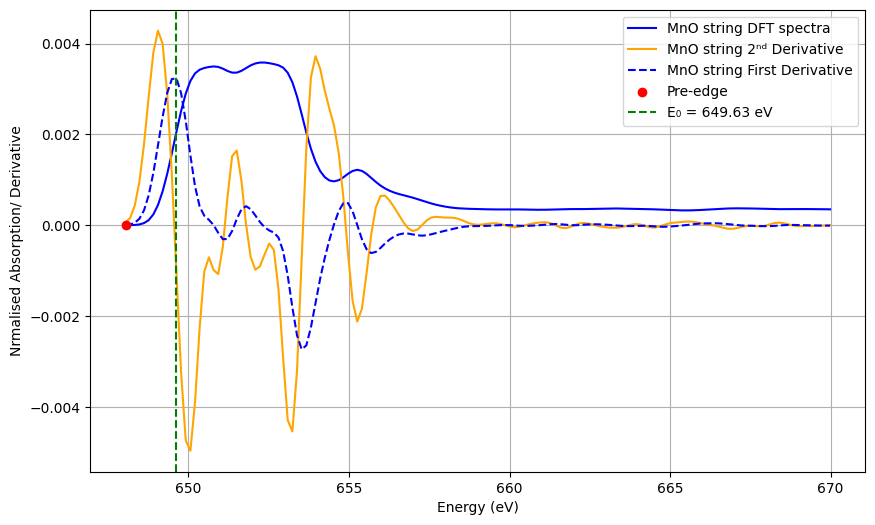

White-line: 652.37 eV
Local maxima in first derivative (x < white-line): [649.62714967 651.79255783]
OMnO error level: 0.0003
Minimum in pre-edge region for OMnO:
  Minimum: x = 648.03, y = 0.0000


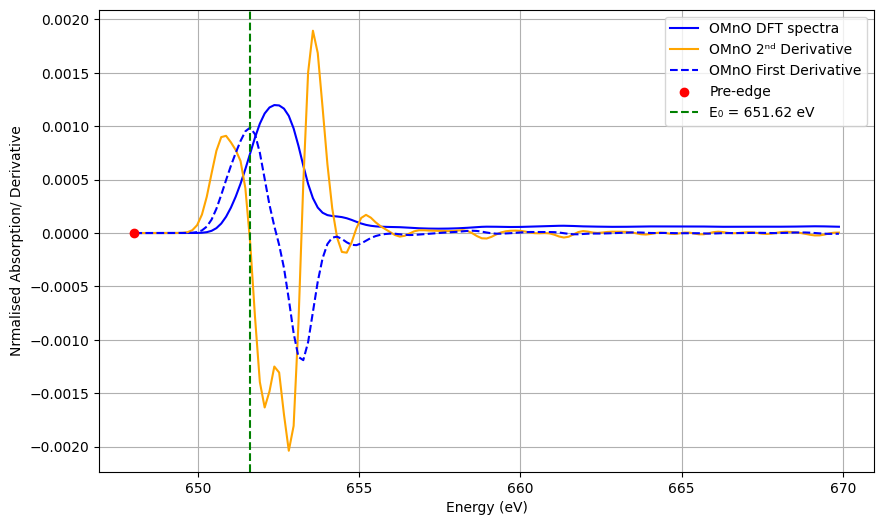

White-line: 652.37 eV
Local maxima in first derivative (x < white-line): [651.62179198]
OMnOMnO error level: 0.0005
Minimum in pre-edge region for OMnOMnO:
  Minimum: x = 648.04, y = 0.0000


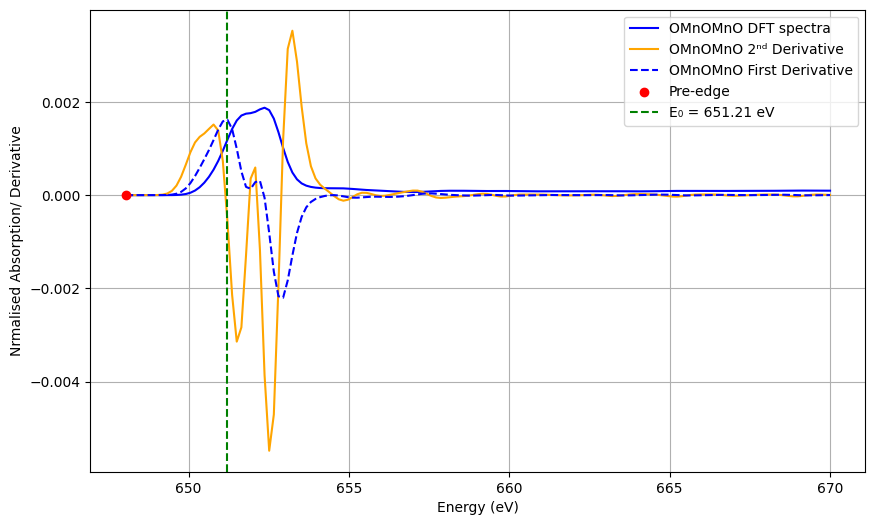

White-line: 652.37 eV
Local maxima in first derivative (x < white-line): [651.21400171]


In [117]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
       
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)
    E1 = E0 * 0.9985
    # Restrict to pre-edge region (before E₀)
    pre_edge_mask = (x < E1)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    
    # Check if pre-edge region has values
    if len(pre_edge_x) == 0 or len(pre_edge_d2y_dx2) == 0:
        print(f"Warning: No data points found in pre-edge region for {structure_name}.")
        return
    
    # Find the true minimum points in the pre-edge region of the second derivative
    min_index = np.argmin(pre_edge_d2y_dx2)  # Index of the absolute minimum
    x_min = pre_edge_x[min_index]
    y_min = y[pre_edge_mask][min_index]
    
    # Display the minimum x and y values
    print(f"Minimum in pre-edge region for {structure_name}:")
    print(f"  Minimum: x = {x_min:.2f}, y = {y_min:.4f}")

    # Plot the original data, the second derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    
    # Plot the second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle='--', color='blue')
    
    # Mark the minimum point
    plt.scatter(x_min, y_min, color='red', label='Pre-edge', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Nrmalised Absorption/ Derivative')
    plt.axvline(E0, color='green', linestyle='--', label=f'E₀ = {E0:.2f} eV')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white-line and local maxima in the first derivative
def find_white_line_and_local_maxima(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the index of the absolute maximum in the y column (white-line)
    abs_max_index = y.argmax()
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]
    print(f'White-line: {x_abs_max} eV')

    # Restrict the first derivative to values where x < white-line
    mask = x < x_abs_max
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]

    # Find local maxima in the first derivative for x values < white-line
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
    
    # Print the x-values of local maxima in the first derivative before the white-line
    print("Local maxima in first derivative (x < white-line):", local_maxima_x)

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Select the columns of interest for each structure
# MnO
x_MnO_ring, y_MnO_ring = extract_data(MnO_ring, "MnO ring")
if x_MnO_ring is not None and y_MnO_ring is not None:
    E0_MnO_ring, dy_dx_MnO_ring= calculate_E0(x_MnO_ring, y_MnO_ring)
    find_pre_edge_minima(x_MnO_ring, y_MnO_ring, E0_MnO_ring, "MnO ring")
    find_white_line_and_local_maxima(x_MnO_ring, y_MnO_ring)

# Mn2O3
x_MnO_string, y_MnO_string = extract_data(MnO_string, "MnO string")
if x_MnO_string is not None and y_MnO_string is not None:
    E0_MnO_string, dy_dx_MnO_string= calculate_E0(x_MnO_string, y_MnO_string)
    find_pre_edge_minima(x_MnO_string, y_MnO_string, E0_MnO_string, "MnO string")
    find_white_line_and_local_maxima(x_MnO_string, y_MnO_string)

# MnO2
x_OMnO_Ledge, y_OMnO_Ledge = extract_data(OMnO_Ledge, "OMnO")
if x_OMnO_Ledge is not None and y_OMnO_Ledge is not None:
    E0_OMnO_Ledge, dy_dx_OMnO_Ledge = calculate_E0(x_OMnO_Ledge, y_OMnO_Ledge)
    find_pre_edge_minima(x_OMnO_Ledge, y_OMnO_Ledge, E0_OMnO_Ledge, "OMnO")
    find_white_line_and_local_maxima(x_OMnO_Ledge, y_OMnO_Ledge)
# MnO2
x_OMnOMnO, y_OMnOMnO = extract_data(OMnOMnO, "OMnOMnO")
if x_OMnOMnO is not None and y_OMnOMnO is not None:
    E0_OMnOMnO, dy_dx_OMnOMnO = calculate_E0(x_OMnOMnO, y_OMnOMnO)
    find_pre_edge_minima(x_OMnOMnO, y_OMnOMnO, E0_OMnOMnO, "OMnOMnO")
    find_white_line_and_local_maxima(x_OMnOMnO, y_OMnOMnO)


# **BROADENIGN OF Co-Mn**

σ = 1.640


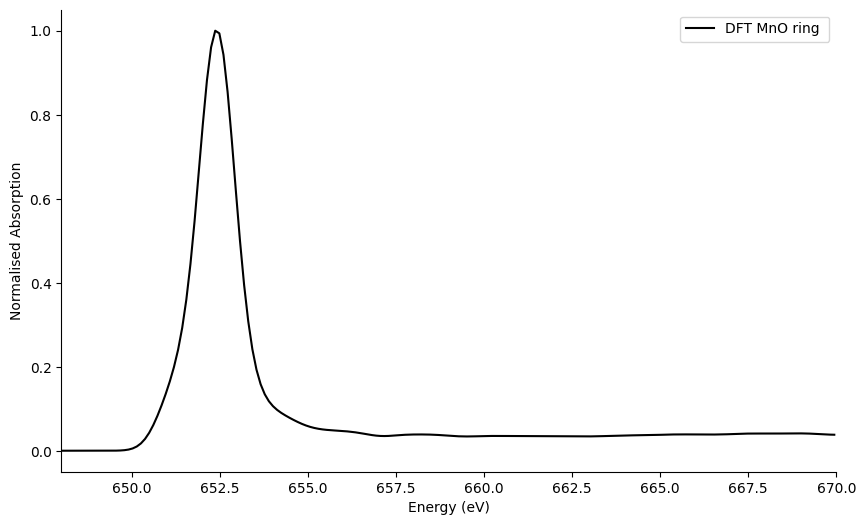

σ = 1.640


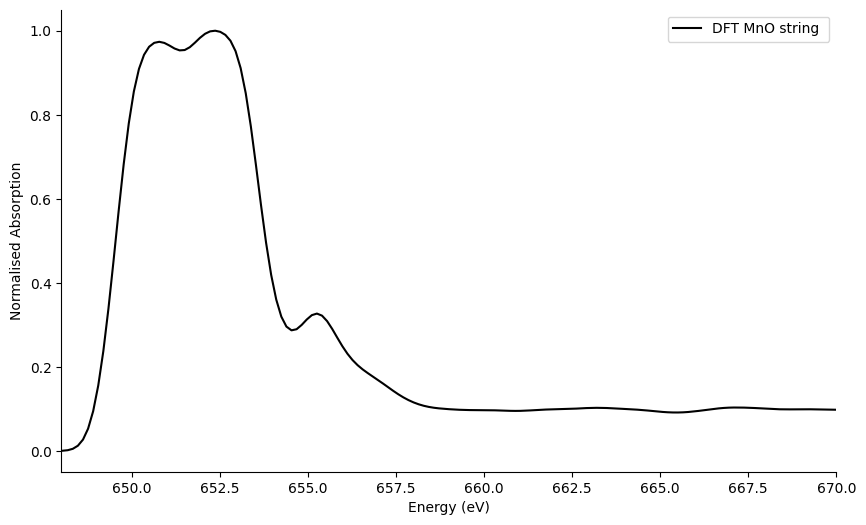

σ = 1.640


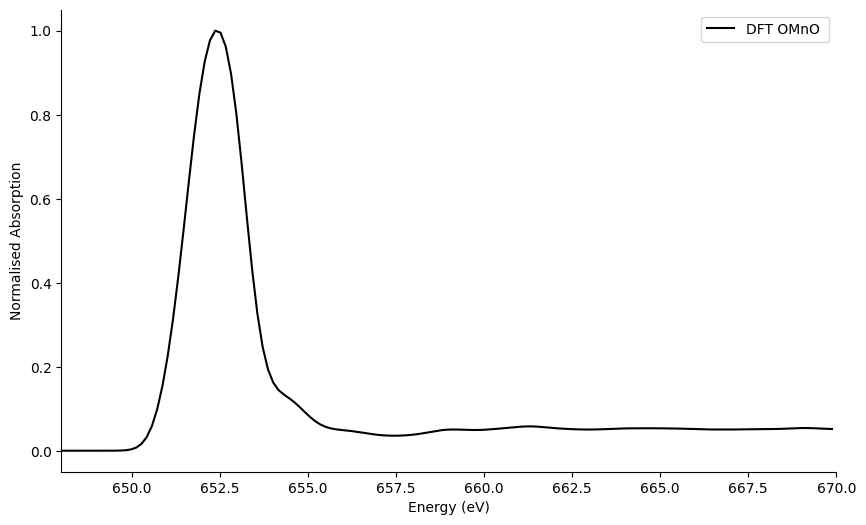

σ = 1.640


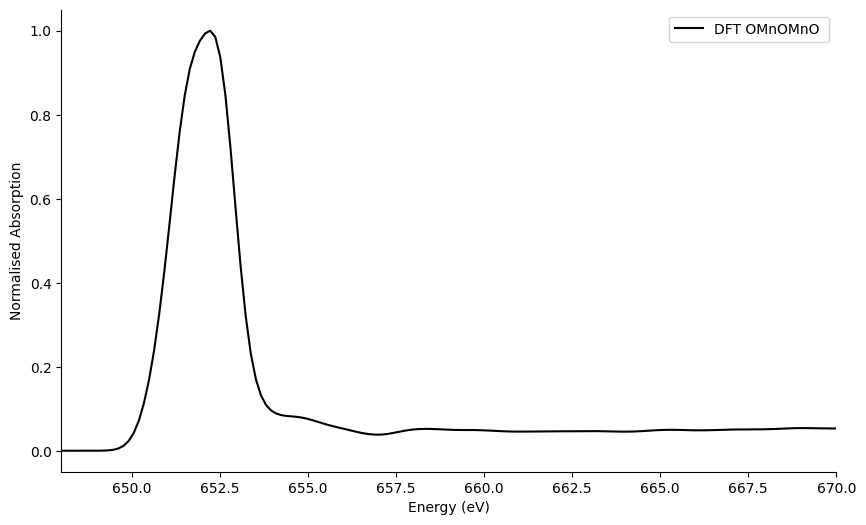

In [118]:
# Function for applying Gaussian broadening
def apply_gaussian_broadening(y_dft, sigma):
    return gaussian_filter1d(y_dft, sigma)

# Apply Gaussian broadening with a given sigma
def apply_broadening_to_structure(dft_df, sigma_avg,name):
    x_dft = dft_df['Energy (eV)'].values
    y_dft = dft_df['Absorption'].values
    
    # Normalize the original DFT absorption spectrum
    y_dft /= np.max(y_dft)

    # Apply Gaussian broadening
    y_dft_broadened = apply_gaussian_broadening(y_dft, sigma_avg)

    # Normalize the broadened DFT absorption data
    renormalized_y_dft = y_dft_broadened / np.max(y_dft_broadened)
    print(f'σ = {sigma_avg:.3f}')
    # Plot the broadened DFT data
    plt.figure(figsize=(10, 6))
    plt.plot(x_dft, renormalized_y_dft, label=f'DFT {name} ', color='black')
    # plt.plot(Mn2O7_exp['x'], Mn2O7_exp['y'], label='experiment', color='blue', linewidth=2)
    # plt.title('Broadened Mn2O7 DFT Spectrum')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption')
    plt.legend()
    # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    # plt.grid()
    plt.xlim(648,670)
    plt.show()

    # Save the renormalized data back into the DataFrame
    dft_df['Absorption'] = renormalized_y_dft

# Compute average sigma from previous results
sigma_avg = 1.64  # Replace these values with actual optimized sigma values

apply_broadening_to_structure(MnO_ring, sigma_avg, "MnO ring")
apply_broadening_to_structure(MnO_string, sigma_avg, "MnO string")
apply_broadening_to_structure(OMnO_Ledge, sigma_avg, "OMnO")
apply_broadening_to_structure(OMnOMnO, sigma_avg, "OMnOMnO")


# **EXTRACT SHOULDERS**

MnO ring error level: 0.2442
Minimum in pre-edge region for MnO ring:
  Minimum: x = 652.25, y = 0.9606


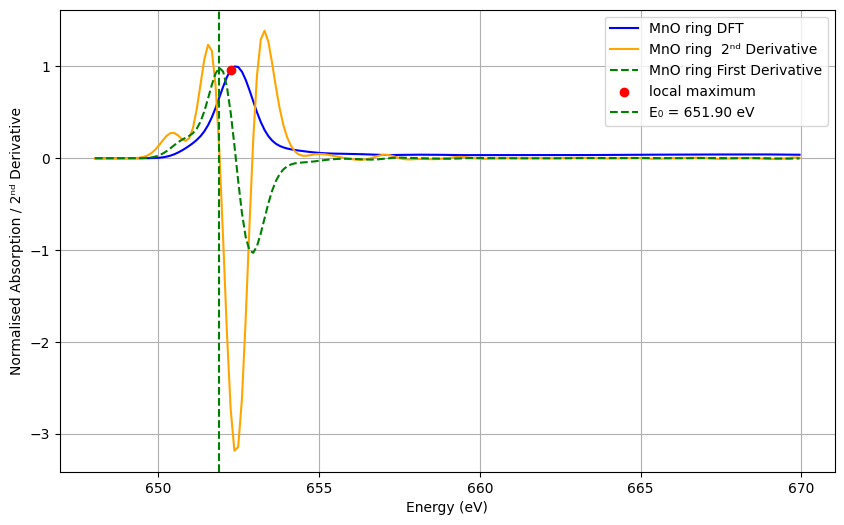

MnO string error level: 0.2048
Minimum in pre-edge region for MnO string:
  Minimum: x = 650.06, y = 0.8555


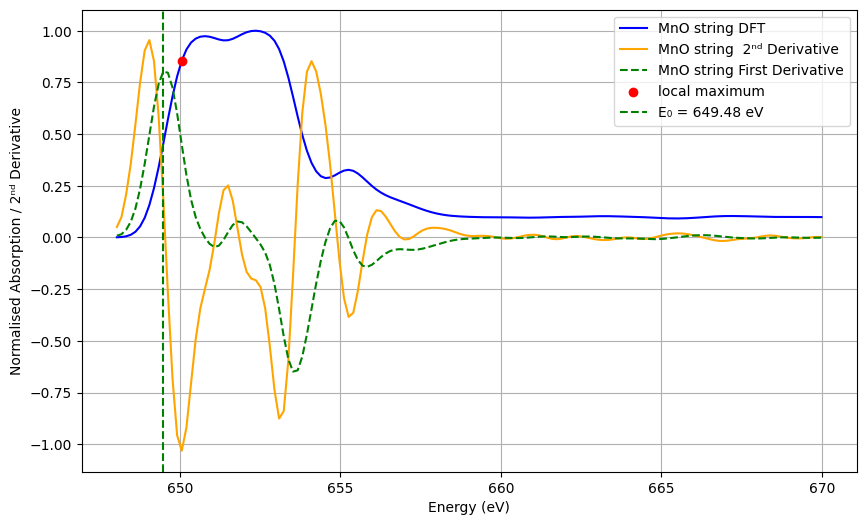

OMnO L-edge error level: 0.2242
Minimum in pre-edge region for OMnO L-edge:
  Minimum: x = 652.22, y = 0.9768


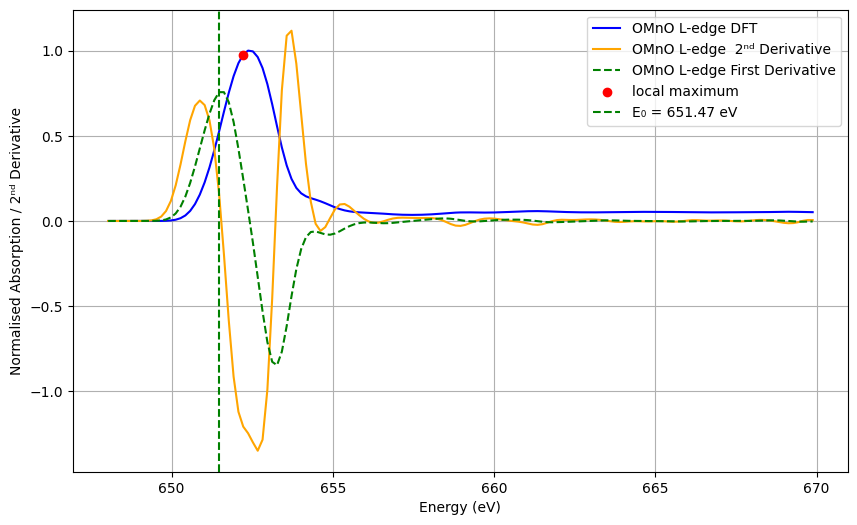

OMnOMnO error level: 0.2318
Minimum in pre-edge region for OMnOMnO:
  Minimum: x = 651.50, y = 0.8452


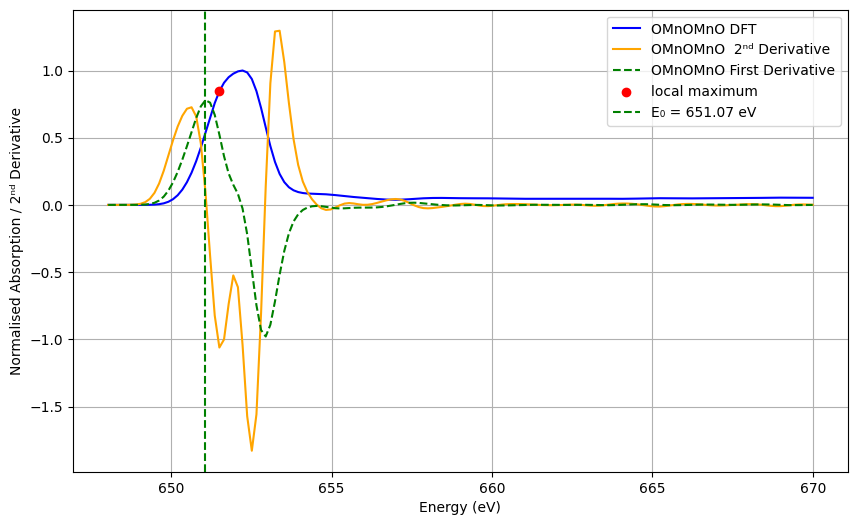

In [119]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Find the white line position (where y is maximum)
    white_line = x[np.argmax(y)]
    
    # Restrict to pre-edge region (between E₀ and white_line)
    pre_edge_mask = (x > E0) & (x < white_line)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    pre_edge_y = y[pre_edge_mask]

    # Find the true minimum point in the pre-edge region of the second derivative
    if len(pre_edge_x) > 0:
        min_index = np.argmin(pre_edge_d2y_dx2)
        x_min = pre_edge_x[min_index]
        y_min = pre_edge_y[min_index]

        # Display the minimum x and y values
        print(f"Minimum in pre-edge region for {structure_name}:")
        print(f"  Minimum: x = {x_min:.2f}, y = {y_min:.4f}")
    else:
        print(f"No valid pre-edge region found for {structure_name} between E₀ and the white line.")

    # Plot the original data, the second derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT', color='blue')
    
    # Plot the second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name}  2ⁿᵈ Derivative', color='orange')
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle= '--',color='green')
    
    # Mark the minimum point if found
    if len(pre_edge_x) > 0:
        plt.scatter(x_min, y_min, color='red', label='local maximum', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption / 2ⁿᵈ Derivative')
    plt.axvline(E0, color='green', linestyle='--', label=f'E₀ = {E0:.2f} eV')
    plt.legend()
    plt.grid(True)
    plt.show()

# MnO
x_MnO_ring = MnO_ring['Energy (eV)'].values
y_MnO_ring = MnO_ring['Absorption'].values
E0_MnO_ring, _ = calculate_E0(x_MnO_ring, y_MnO_ring)
find_pre_edge_minima(x_MnO_ring, y_MnO_ring, E0_MnO_ring, "MnO ring")

# Mn2O3
x_MnO_string = MnO_string['Energy (eV)'].values
y_MnO_string = MnO_string['Absorption'].values
E0_MnO_string, _ = calculate_E0(x_MnO_string, y_MnO_string)
find_pre_edge_minima(x_MnO_string, y_MnO_string, E0_MnO_string, "MnO string")

# MnO2
x_OMnO_Ledge = OMnO_Ledge['Energy (eV)'].values
y_OMnO_Ledge = OMnO_Ledge['Absorption'].values
E0_OMnO_Ledge, _ = calculate_E0(x_OMnO_Ledge, y_OMnO_Ledge)
find_pre_edge_minima(x_OMnO_Ledge, y_OMnO_Ledge, E0_OMnO_Ledge, "OMnO L-edge")
# MnO2
x_OMnOMnO = OMnOMnO['Energy (eV)'].values
y_OMnOMnO = OMnOMnO['Absorption'].values
E0_OMnOMnO, _ = calculate_E0(x_OMnOMnO, y_OMnOMnO)
find_pre_edge_minima(x_OMnOMnO, y_OMnOMnO, E0_OMnOMnO, "OMnOMnO")


# **EXTRACT WHITE-LINE**

white line: 652.37 eV


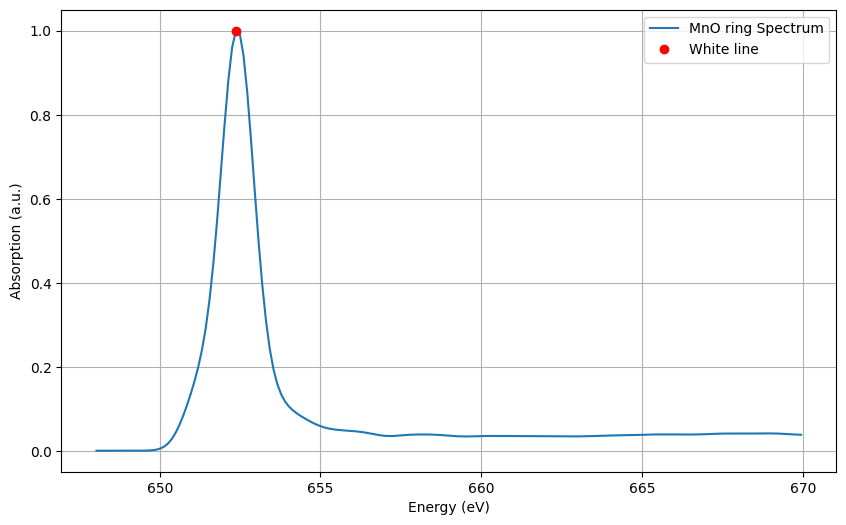

white line: 652.37 eV


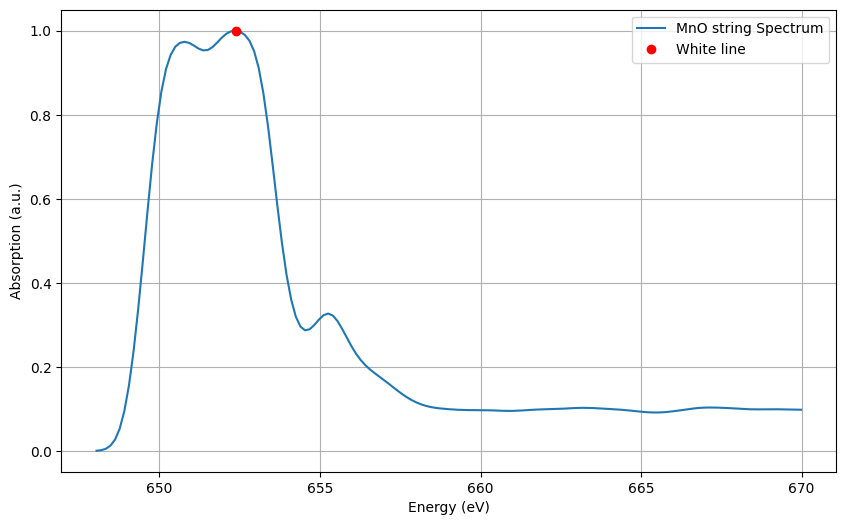

white line: 652.37 eV


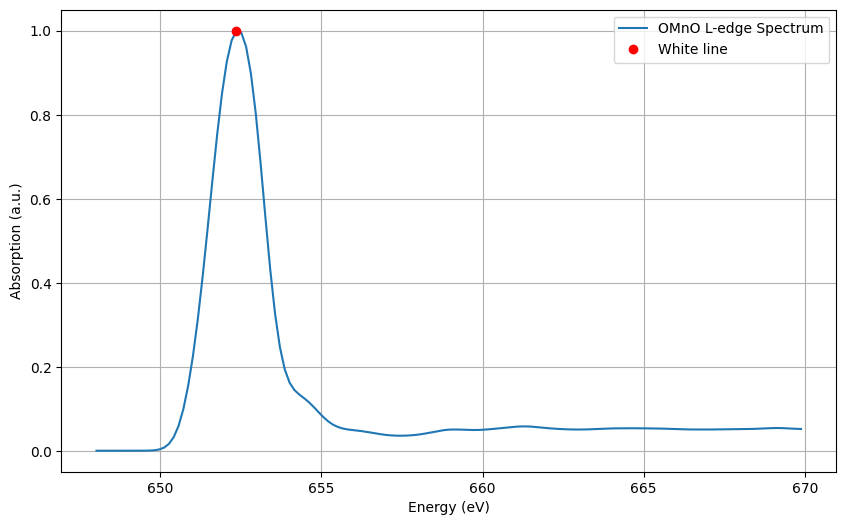

white line: 652.225500214069 eV


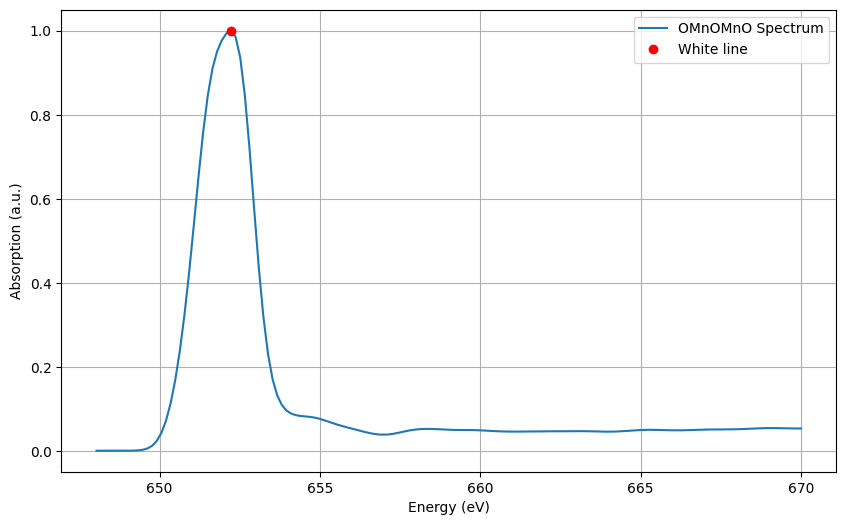

In [120]:
# Function to plot spectra and mark the absolute maximum (whiteline)
def plot_spectrum_with_whiteline(data, structure_name):
    x = data['Energy (eV)']
    y = data['Absorption']

    # Find the index of the absolute maximum in the y column
    abs_max_index = y.idxmax()
    # Get the corresponding x and y values for the whiteline
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]
    print(f'white line: {x_abs_max} eV')

    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} Spectrum')
    plt.plot(x_abs_max, y_abs_max, 'ro', label='White line ')  # Mark the whiteline

    # Label the plot
    # plt.title(f'{structure_name}: Spectrum with Whiteline')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot each spectrum with whiteline marked
plot_spectrum_with_whiteline(MnO_ring, "MnO ring")
plot_spectrum_with_whiteline(MnO_string, "MnO string")
plot_spectrum_with_whiteline(OMnO_Ledge, "OMnO L-edge")
plot_spectrum_with_whiteline(OMnOMnO, "OMnOMnO")


# **EXTRACT FIRST POST-EDGE MAXIMUM**

MnO ring error level: 0.2442
Local minima in second derivative (x > white line) for MnO ring:
  x = 654.60, y = 0.0264
  x = 656.24, y = -0.0170
  x = 657.76, y = -0.0126
  x = 658.58, y = -0.0103
  x = 660.10, y = -0.0058
  x = 661.27, y = -0.0008
  x = 662.09, y = -0.0011
  x = 663.97, y = -0.0024
  x = 665.49, y = -0.0060
  x = 667.48, y = -0.0067
  x = 669.12, y = -0.0091


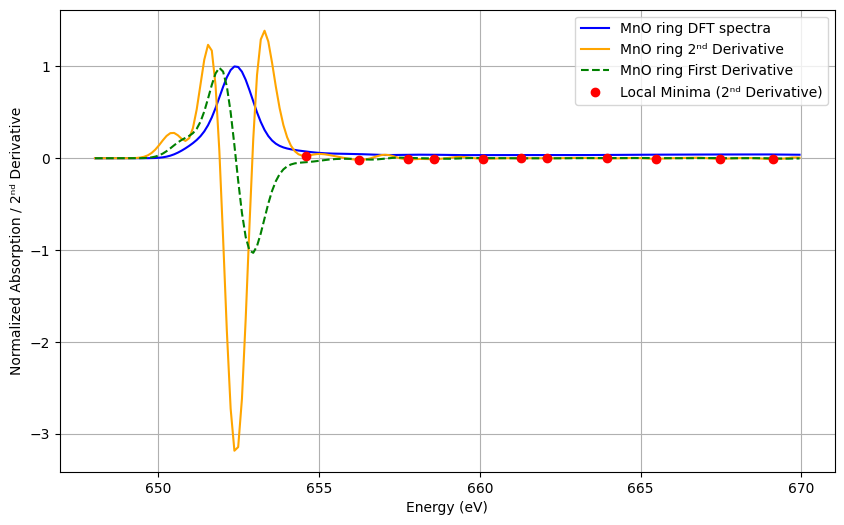

MnO string error level: 0.2048
Local minima in second derivative (x > white line) for MnO string:
  x = 653.09, y = -0.8759
  x = 655.26, y = -0.3844
  x = 656.99, y = -0.0094
  x = 659.15, y = 0.0069
  x = 660.17, y = -0.0063
  x = 661.75, y = -0.0085
  x = 663.20, y = -0.0127
  x = 664.50, y = -0.0075
  x = 666.95, y = -0.0170
  x = 669.26, y = -0.0044


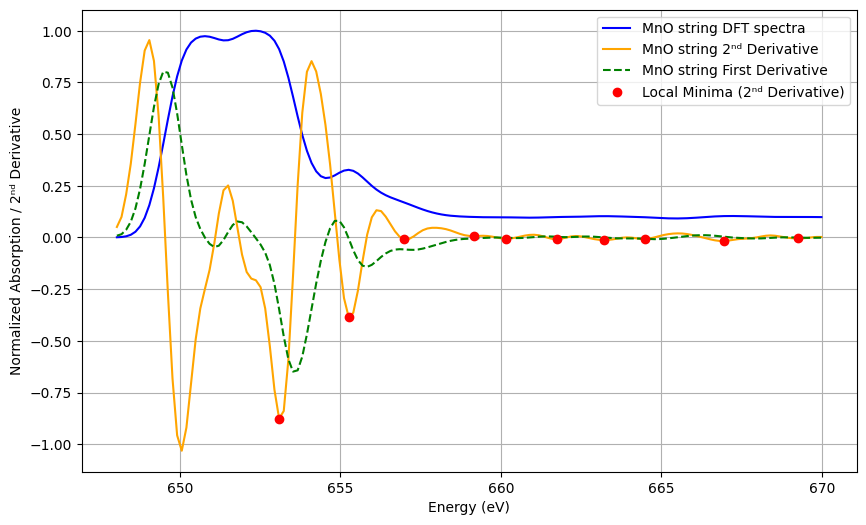

OMnO error level: 0.2242
Local minima in second derivative (x > white line) for OMnO:
  x = 652.67, y = -1.3486
  x = 654.61, y = -0.0583
  x = 656.26, y = -0.0110
  x = 657.76, y = 0.0173
  x = 658.95, y = -0.0290
  x = 661.35, y = -0.0228
  x = 662.40, y = 0.0056
  x = 663.89, y = -0.0061
  x = 664.79, y = -0.0026
  x = 665.54, y = -0.0044
  x = 666.74, y = 0.0020
  x = 667.63, y = -0.0026
  x = 669.13, y = -0.0133


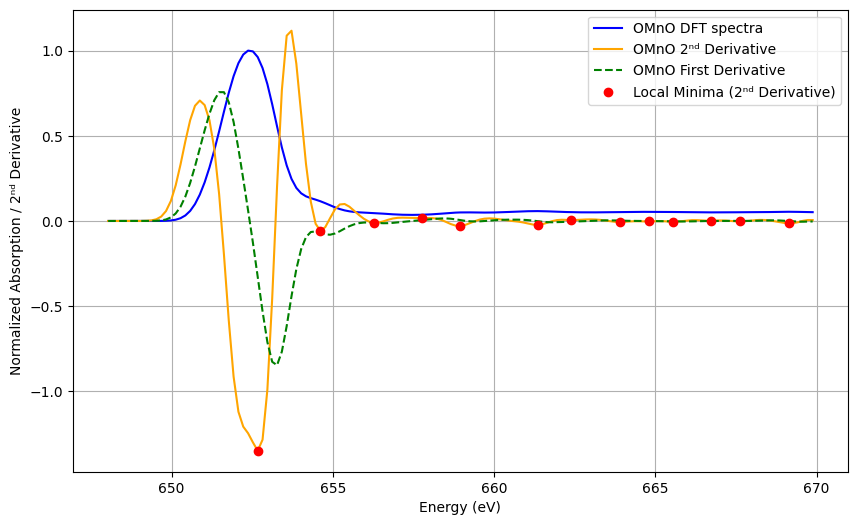

OMnOMnO error level: 0.2318
Local minima in second derivative (x > white line) for OMnOMnO:
  x = 652.51, y = -1.8290
  x = 654.83, y = -0.0373
  x = 655.98, y = 0.0006
  x = 658.01, y = -0.0256
  x = 659.88, y = -0.0090
  x = 661.91, y = -0.0023
  x = 663.21, y = -0.0063
  x = 665.23, y = -0.0122
  x = 667.11, y = -0.0046
  x = 668.84, y = -0.0093


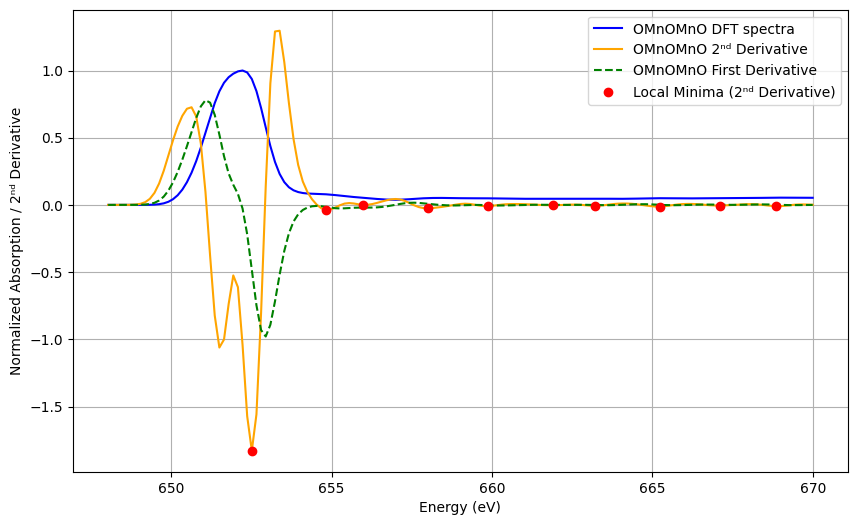

In [121]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for x > white line
def find_post_white_line_minima(x, y, x_white_line, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Restrict the search to x > white line
    post_white_line_mask = (x > x_white_line)
    post_white_line_x = x[post_white_line_mask]
    post_white_line_d2y_dx2 = d2y_dx2[post_white_line_mask]
    
    # Find local minima (peaks of -d2y_dx2) in the second derivative for x > white line
    minima_indices, _ = find_peaks(-post_white_line_d2y_dx2)
    local_minima_x = post_white_line_x[minima_indices]
    local_minima_y = post_white_line_d2y_dx2[minima_indices]
    
    # Display the minima x-values and corresponding y-values
    print(f"Local minima in second derivative (x > white line) for {structure_name}:")
    for x_min, y_min in zip(local_minima_x, local_minima_y):
        print(f"  x = {x_min:.2f}, y = {y_min:.4f}")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Plot original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    
    # Plot second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle='--',color='green')
    # Mark the minima points on the second derivative graph
    plt.scatter(local_minima_x, local_minima_y, color='red', label='Local Minima (2ⁿᵈ Derivative)', zorder=5)
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white-line and local maxima in the first derivative
def find_white_line_and_local_maxima_and_minima(x, y, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the white-line maximum in the original spectrum
    abs_max_index = y.argmax()
    x_white_line = x[abs_max_index]
    y_white_line = y[abs_max_index]
   
    # Restrict to x < white line for local maxima in first derivative
    mask = x < x_white_line
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]
    
    # Find local maxima in the first derivative where x < white line
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
        
    # Call function to find local minima in second derivative where x > white line
    find_post_white_line_minima(x, y, x_white_line, structure_name)

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Analysis for each structure
# MnO ring
x_MnO_ring, y_MnO_ring = extract_data(MnO_ring, "MnO ring")
if x_MnO_ring is not None and y_MnO_ring is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_ring, y_MnO_ring, "MnO ring")

# MnO string
x_MnO_string, y_MnO_string = extract_data(MnO_string, "MnO string")
if x_MnO_string is not None and y_MnO_string is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_string, y_MnO_string, "MnO string")

# OMnO
x_OMnO_Ledge, y_OMnO_Ledge = extract_data(OMnO_Ledge, "OMnO")
if x_OMnO_Ledge is not None and y_OMnO_Ledge is not None:
    find_white_line_and_local_maxima_and_minima(x_OMnO_Ledge, y_OMnO_Ledge, "OMnO")

# OMnOMnO
x_OMnOMnO, y_OMnOMnO= extract_data(OMnOMnO, "OMnOMnO")
if x_OMnOMnO is not None and y_OMnOMnO is not None:
    find_white_line_and_local_maxima_and_minima(x_OMnOMnO, y_OMnOMnO, "OMnOMnO")


# **EXTRACTING MnO STRING SHOULDER**

MnO string error level: 0.2048
White-line: 652.37 eV for MnO string
Local maxima in first derivative (x < white-line): [649.48278913 651.79255783]
Zero-crossings of the first derivative for MnO string (x < white line): [np.float64(650.7797823548972), np.float64(651.4062207314095)]


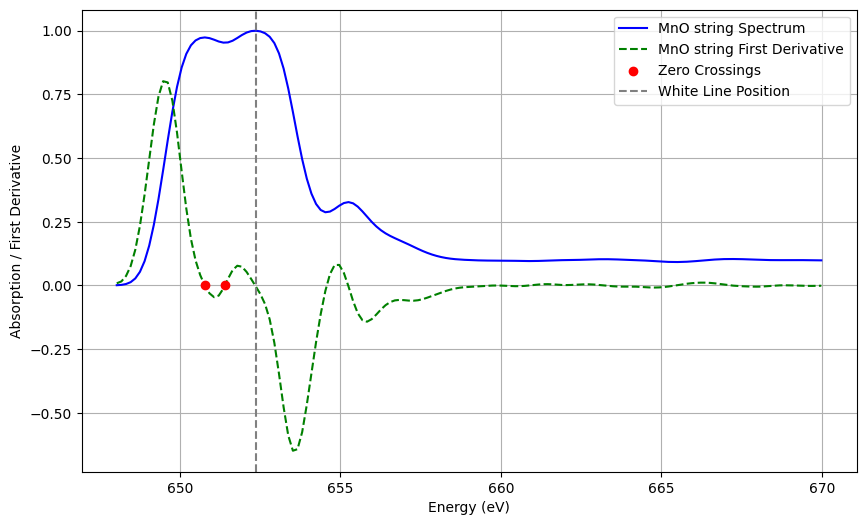

In [122]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find x-values where the first derivative crosses zero for x < white line
def find_zero_crossings(x, y, x_white_line, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Restrict to values of x < white line
    mask = x < x_white_line
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]
    
    # Identify zero-crossings
    zero_crossings_x = []
    zero_crossings_y = []
    
    for i in range(1, len(dy_dx_below_white_line)):
        if (dy_dx_below_white_line[i-1] > 0 and dy_dx_below_white_line[i] < 0) or \
           (dy_dx_below_white_line[i-1] < 0 and dy_dx_below_white_line[i] > 0):
            # Linear interpolation to find exact zero-crossing point
            x_zero = x_below_white_line[i-1] - dy_dx_below_white_line[i-1] * (
                x_below_white_line[i] - x_below_white_line[i-1]
            ) / (dy_dx_below_white_line[i] - dy_dx_below_white_line[i-1])
            zero_crossings_x.append(x_zero)
            zero_crossings_y.append(0)  # First derivative is zero at crossing
    
    # Print and plot the zero-crossing points
    print(f"Zero-crossings of the first derivative for {structure_name} (x < white line): {zero_crossings_x}")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} Spectrum', color='blue')
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle='--', color='green')
    plt.scatter(zero_crossings_x, zero_crossings_y, color='red', label='Zero Crossings', zorder=5)
    plt.axvline(x=x_white_line, color='gray', linestyle='--', label='White Line Position')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption / First Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white-line and local maxima in the first derivative
def find_white_line_and_local_maxima(x, y, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
        
    # Find the index of the absolute maximum in the y column (white-line)
    abs_max_index = y.argmax()
    x_white_line = x[abs_max_index]
    y_white_line = y[abs_max_index]
    print(f'White-line: {x_white_line} eV for {structure_name}')

    # Restrict the first derivative to values where x < white-line
    mask = x < x_white_line
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]

    # Find local maxima in the first derivative for x values < white-line
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
    
    # Print the x-values of local maxima in the first derivative before the white-line
    print("Local maxima in first derivative (x < white-line):", local_maxima_x)

    return x_white_line

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# MnO string
x_MnO_string, y_MnO_string = extract_data(MnO_string, "MnO string")
if x_MnO_string is not None and y_MnO_string is not None:
    # Calculate E₀ and the first derivative
    E0_MnO_string, dy_dx_MnO_string = calculate_E0(x_MnO_string, y_MnO_string)
    
    # Find the white line and local maxima in the first derivative
    x_white_line_MnO_string = find_white_line_and_local_maxima(x_MnO_string, y_MnO_string, "MnO string")
    
    # Find zero-crossings of the first derivative before the white line
    find_zero_crossings(x_MnO_string, y_MnO_string, x_white_line_MnO_string, "MnO string")



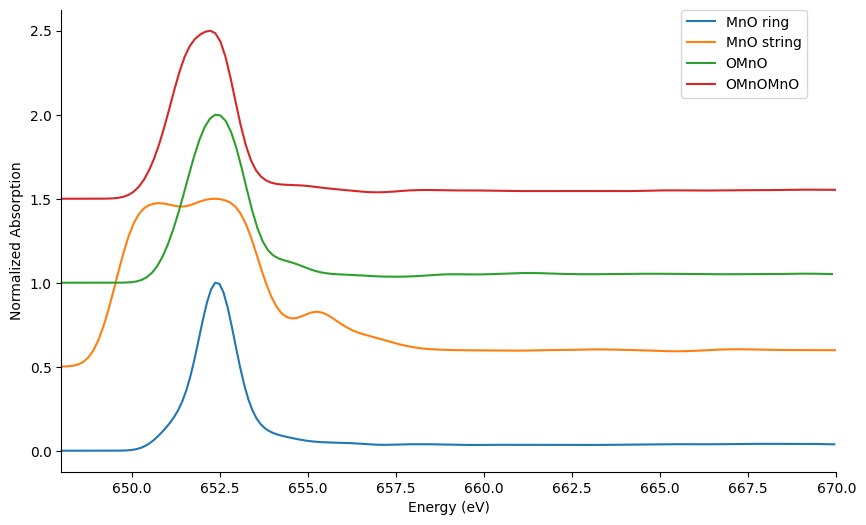

In [123]:

# Function to plot stacked XANES EXP spectra with upward shift
def plot_stacked_xanes_spectra(DFT_data_list, structure_names, shift_value=0.5):
    plt.figure(figsize=(10, 6))  # Set figure size
    
    # Loop over each DFT dataset and apply an upward shift
    for i, (x, y, structure_name) in enumerate(DFT_data_list):
        # Apply a shift upwards for each subsequent spectrum
        shifted_y = y + i * shift_value
        
        # Plot the spectrum with a label indicating the structure name
        plt.plot(x, shifted_y, label=f'{structure_name}')
    
    # Customize the plot
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1), borderaxespad=0)
    plt.xlim(648, 670)
    
    # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()
   
# Convert to numpy arrays for plotting
x_MnO_ring = MnO_ring['Energy (eV)'].values
y_MnO_ring = MnO_ring['Absorption'].values

x_MnO_string = MnO_string['Energy (eV)'].values
y_MnO_string = MnO_string['Absorption'].values

x_OMnO_Ledge = OMnO_Ledge ['Energy (eV)'].values
y_OMnO_Ledge  = OMnO_Ledge ['Absorption'].values

x_OMnOMnO = OMnOMnO['Energy (eV)'].values
y_OMnOMnO =OMnOMnO['Absorption'].values

# Create a list of tuples with (x, y, structure_name) for each dataset
DFT_data_list = [
    (x_MnO_ring, y_MnO_ring, "MnO ring"),
    (x_MnO_string, y_MnO_string, "MnO string"),
    (x_OMnO_Ledge, y_OMnO_Ledge, "OMnO"),
    (x_OMnOMnO , y_OMnOMnO, "OMnOMnO")
]

# Call the function to plot the stacked spectra with a shift value of 0.5
plot_stacked_xanes_spectra(DFT_data_list, ["MnO ring", "MnO string", "OMnO", "OMnOMnO "], shift_value=0.5)


In [124]:
# Locate the index of the maximum Y value for the MnO experimental and DFT data
max_MnO_exp = MnO_DFT['Absorption'].idxmax()
max_MnO_DFT = MnO_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO_exp = MnO_DFT.loc[max_MnO_exp, 'Energy (eV)']
x_max_MnO_DFT = MnO_DFT.loc[max_MnO_DFT, 'Energy (eV)']
shift_value_MnO =x_max_MnO_exp - x_max_MnO_DFT
MnO_DFT['Energy (eV)'] += shift_value_MnO

# Print the max X values
print(f'MnO_experiment max Y at Energy (eV): {x_max_MnO_exp}')
print(f'MnO_DFT max Y at Energy (eV): {x_max_MnO_DFT}')
print(f'The shift energy value for MnO2 (eV): {shift_value_MnO}')

# Locate the index of the maximum Y value for the Mn2O3 experimental and DFT data
max_Mn2O3_exp = MnO_DFT['Absorption'].idxmax()
max_Mn2O3_DFT = Mn2O3_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_Mn2O3_exp = MnO_DFT.loc[max_Mn2O3_exp, 'Energy (eV)']
x_max_Mn2O3_DFT = Mn2O3_DFT.loc[max_Mn2O3_DFT, 'Energy (eV)']
shift_value_Mn2O3 =x_max_Mn2O3_exp - x_max_Mn2O3_DFT 
Mn2O3_DFT['Energy (eV)'] += shift_value_Mn2O3

# Locate the index of the maximum Y value for the MnO2 experimental and DFT data
max_MnO2_exp = MnO_DFT['Absorption'].idxmax()
max_MnO2_DFT = MnO2_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO2_exp = MnO_DFT.loc[max_MnO2_exp, 'Energy (eV)']
x_max_MnO2_DFT = MnO2_DFT.loc[max_MnO2_DFT, 'Energy (eV)']
shift_value_MnO2 =x_max_MnO2_exp - x_max_MnO2_DFT 
MnO2_DFT['Energy (eV)'] += shift_value_MnO2


# Locate the index of the maximum Y value for the MnO2 experimental and DFT data
max_MnO2_exp = MnO_DFT['Absorption'].idxmax()
max_Mn2O7_DFT = Mn2O7_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_Mn2O7_exp = MnO_DFT.loc[max_MnO2_exp, 'Energy (eV)']
x_max_Mn2O7_DFT = Mn2O7_DFT.loc[max_Mn2O7_DFT, 'Energy (eV)']
shift_value_Mn2O7 =x_max_Mn2O7_exp - x_max_Mn2O7_DFT 
Mn2O7_DFT['Energy (eV)'] += shift_value_Mn2O7
print(f'Mn2O7_experiment max Y at Energy (eV): {shift_value_Mn2O7}')

MnO_experiment max Y at Energy (eV): 652.37
MnO_DFT max Y at Energy (eV): 652.37
The shift energy value for MnO2 (eV): 0.0
Mn2O7_experiment max Y at Energy (eV): -0.7300000000000182


# **Classification of Co-Mn**

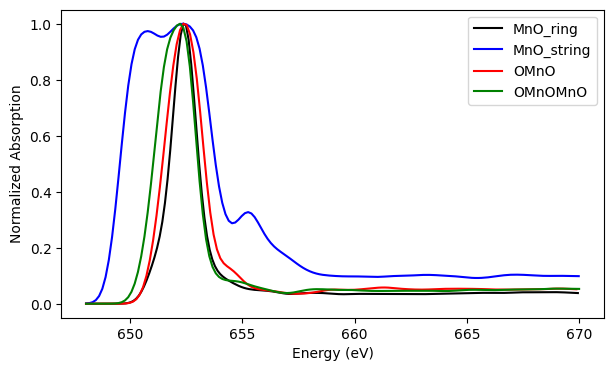

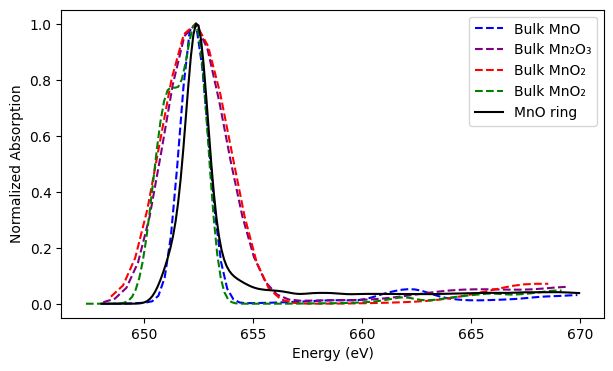

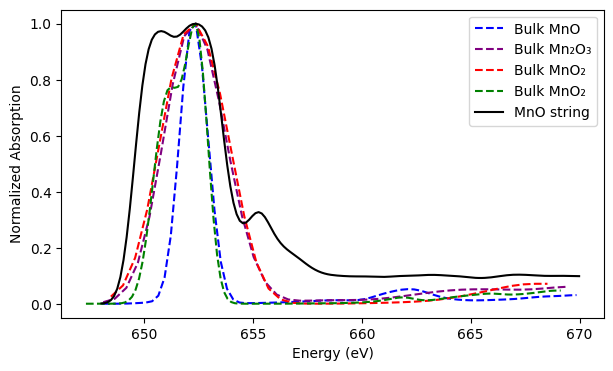

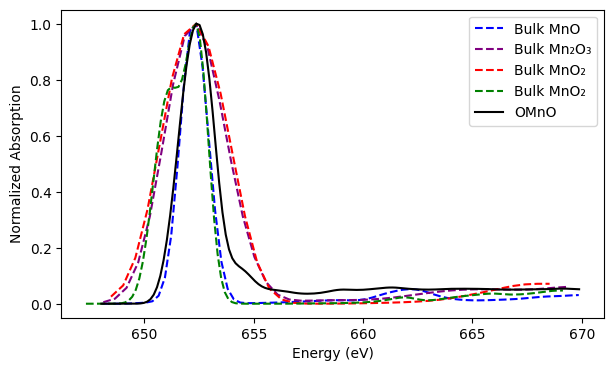

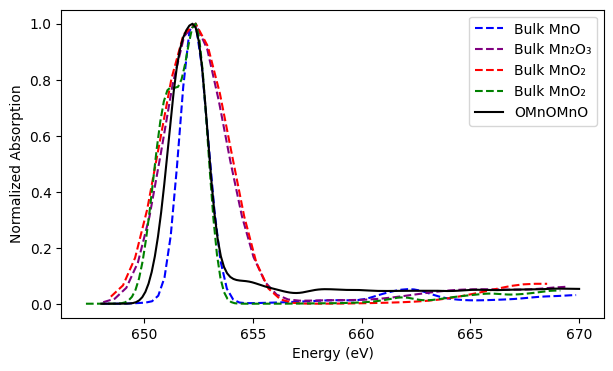

In [125]:
# # Plot for MnO2
plt.figure(figsize=(7, 4))
plt.plot(MnO_ring["Energy (eV)"], MnO_ring['Absorption'], color='Black', label='MnO_ring')
plt.plot(MnO_string["Energy (eV)"], MnO_string['Absorption'], color='Blue', label='MnO_string')
plt.plot(OMnO_Ledge["Energy (eV)"], OMnO_Ledge['Absorption'], color='Red', label='OMnO')
plt.plot(OMnOMnO["Energy (eV)"], OMnOMnO['Absorption'], color='Green', label='OMnOMnO')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# Plot for MnO
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='Bulk MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='purple', label='Bulk Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='Bulk MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='Bulk MnO₂',linestyle='--')
plt.plot(MnO_ring["Energy (eV)"], MnO_ring['Absorption'], color='Black', label='MnO ring')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# Plot for Mn2O3
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='Bulk MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='purple', label='Bulk Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='Bulk MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='Bulk MnO₂',linestyle='--')
plt.plot(MnO_string["Energy (eV)"], MnO_string['Absorption'], color='Black', label='MnO string')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# # Plot for MnO2
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='Bulk MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='purple', label='Bulk Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='Bulk MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='Bulk MnO₂',linestyle='--')
plt.plot(OMnO_Ledge["Energy (eV)"], OMnO_Ledge['Absorption'], color='Black', label='OMnO')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# # Plot for MnO2
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='Bulk MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='purple', label='Bulk Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='Bulk MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='Bulk MnO₂',linestyle='--')
plt.plot(OMnOMnO["Energy (eV)"], OMnOMnO['Absorption'], color='Black', label='OMnOMnO')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()